In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import seaborn as sns
import ruptures as rpt
from scipy.signal import find_peaks
from sklearn.decomposition import PCA as SKPCA



## Where to change the patient file path

In [5]:
sub = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\OtherData\OFFMED_ONSTIM_EC_L_left.csv')

## Functions

In [169]:
def convertDF(path):
    '''
    Converts a landmark dataframe, preferring hand_index == 0 when duplicates occur.
    '''
    df = pd.read_csv(path)

    # Filter to Right Hand only
    df = df[df['hand_label'] == 'Right']

    # Ensure proper types
    df['frame_number'] = df['frame_number'].astype(int)
    df['landmark_index'] = df['landmark_index'].astype(int)

    print(len(df))

    # Sort so that hand_index == 0 comes first
    df = df.sort_values(by=['frame_number', 'landmark_index', 'hand_index'], ascending=[True, True, True])
    print(len(df))

    # Drop duplicates per (frame_number, landmark_index), keeping hand_index == 0 when it exists
    df = df.drop_duplicates(subset=['frame_number', 'landmark_index'], keep='first')
    print(len(df))

    print(f"Filtered DataFrame shape: {df.shape}")

    # Melt to long format
    df_long = df.melt(
        id_vars=['frame_number', 'landmark_index'],
        value_vars=['x', 'y', 'z', 'score'],
        var_name='coord',
        value_name='value'
    )

    # Build pivot column names
    def make_column_name(row):
        base = f'Landmark{row["landmark_index"]}'
        if row['coord'] == 'x':
            return base
        elif row['coord'] == 'y':
            return base + '.1'
        elif row['coord'] == 'z':
            return base + '.2'
        elif row['coord'] == 'score':
            return base + '_score'

    df_long['landmark_coord'] = df_long.apply(make_column_name, axis=1)

    # Pivot to wide format
    df_wide = df_long.pivot_table(
        index='frame_number',
        columns='landmark_coord',
        values='value',
        aggfunc='first'
    ).reset_index()

    # Sort columns
    df_wide = df_wide.reindex(
        sorted(df_wide.columns, key=lambda x: (-1 if x == 'frame_number' else int(x.split('Landmark')[1].split('.')[0].split('_')[0]), x)),
        axis=1
    )

    return df_wide


In [141]:
def clean_df(df):
    '''cleans and interpolates the data depending upon the likelihood score'''

    # Copy your DataFrame
    cleaned_df = df.copy()

    marker_names = {'Landmark0', 'Landmark1', 'Landmark2', 'Landmark3', 'Landmark4', 'Landmark5', 'Landmark6', 'Landmark7', 'Landmark8', 'Landmark9', 'Landmark10', 'Landmark11', 'Landmark12',
                    'Landmark13', 'Landmark14', 'Landmark15', 'Landmark16', 'Landmark17', 'Landmark18', 'Landmark19', 'Landmark20'}

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        z_col = marker + '.2'
        l_col = marker + '_score'

        # Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col, z_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col, z_col]] = cleaned_df[[x_col, y_col, z_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col, z_col]] = 0

    return cleaned_df


In [142]:
def hand_PS_mov(df, t):
    '''reports the peaks and the troughs'''

    start = t[0]
    stop = t[-1]

    fTip1 = df['fTip1']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y = fTip1[start_idx:end_idx]
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=30, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, 'NA'

In [317]:
def arm_EF_mov(df, t):
    '''reports the peaks and troughs'''

    fs = 100
    
    start = t[0]
    stop = t[-1]

    fTip1 = df['MCP1.1']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y = fTip1[start_idx:end_idx]
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=30, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, 'NA'



In [318]:

def hand_OC_mov(df, t):
    '''Reports the peaks and troughs from the Euclidean distance'''

    start = t[0]
    stop = t[-1]

    fTip2y = df['fTip2.1']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y = fTip2y[start_idx:end_idx]
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=30, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, y

In [319]:
def compute_peaks_troughs(row):
    base = row['dataset']  # like 'b1', 't2', etc.
    
    # Define both front and side keys
    dff = dataframes.get(base + 'f')
    dfs = dataframes.get(base + 's')

    if df is None:
        print(f"Warning: DataFrame for key '{base}' not found.")
        return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])

    try:
        if row['movement'] == 'hand_OC':
            return pd.Series(hand_OC_mov(dfs, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        elif row['movement'] == 'hand_PS':
            return pd.Series(hand_PS_mov(dff, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        elif row['movement'] == 'arm_EF':
            return pd.Series(arm_EF_mov(dff, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        else:
            return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])
    except Exception as e:
        print(f"Error processing row {row.name}: {e}")
        return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])


In [19]:
def run_PCA(X, indices, view, mov, n_components=None):
    '''Calculates PCA for one camera view and one probe position'''

    # 1. Takes into consideration if there are indices or not (helpful for when looking at specific movement)
    if indices is not None:
        X_subset = X.iloc[indices[0]:indices[1]+1]
    else:
        X_subset = X

    # 2. Drop columns containing '.2' --> dropping likelihood rows
    df = X_subset.loc[:, ~X_subset.columns.str.contains(r'\.2')]

    # 3. Remove constant columns --> gets rid of runs that were unsuccessful 
    stds = df.std(axis=0)
    df = df.loc[:, stds != 0]

    # 4. Standardize the data --> standardize mean to 0 and std to 1 (suggested from geeks for geeks)
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(df)

    # 5. Apply PCA
    pca = SKPCA(n_components=n_components)
    X_pca = pca.fit_transform(X_standardized)

    # 6. Output
    explained_variance_ratio = pca.explained_variance_ratio_
    explained_variance = pca.explained_variance_
    pca_components = pca.components_ # direction (vectors) the define the PCs in the original feature space pca_components[0] are the scores in regards to PCA1



    return X_pca, explained_variance_ratio, explained_variance, pca_components


def trim_initial_zeros(df):
    """
    Trims the DataFrame by removing rows at the beginning where ANY column is 0.
    Once all columns have non-zero values, keeps everything from that row on.
    Necessary because rows were set to 0 when filtering likelihood
    """
    mask = (df != 0).any(axis=1)
    first_valid_index = mask.idxmax()  # first row where any column is non-zero
    return df.loc[first_valid_index:].reset_index(drop=True)

In [143]:
def average_close_indices(index_list, threshold=100):
    if not index_list:
        return []

    averaged = []
    current_group = [index_list[0]]

    for i in range(1, len(index_list)):
        if abs(index_list[i] - sum(current_group)/len(current_group)) <= threshold:
            current_group.append(index_list[i])
        else:
            # Commit the average of the current group
            averaged.append(int(sum(current_group)/len(current_group)))
            # Start new group
            current_group = [index_list[i]]

    # Don't forget the last group
    averaged.append(int(sum(current_group)/len(current_group)))
    return averaged


## Creates dataframes for each depth

In [170]:
# Define the label for this file
label = 'data1'  # You can name it whatever you want

# Process the file using convertDF
df = convertDF(sub)
print(len(df))

# implement likelihood
cleaned_df = clean_df(df)

# Store it in a dictionary
dataframes = {label: cleaned_df}

# Now dataframes['data1'] will give you the processed DataFrame
#print(dataframes[label])



27825
27825
26565
Filtered DataFrame shape: (26565, 8)
1265


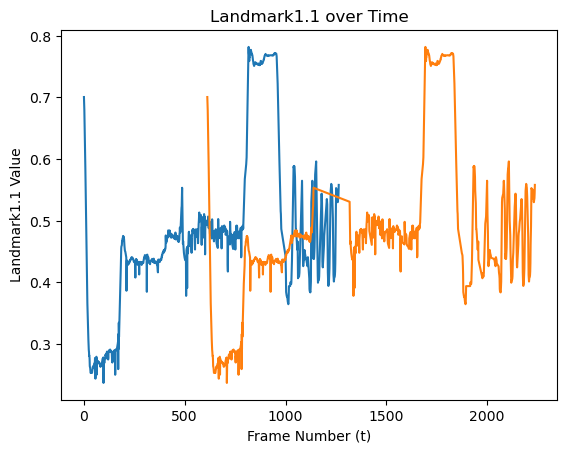

In [171]:
x = cleaned_df['Landmark1.1'].to_numpy()
t = np.arange(len(cleaned_df))  # Create an array from 0 to N-1
t2 = cleaned_df['frame_number'].to_numpy()

plt.plot(t, x)
plt.plot(t2,x)
plt.xlabel('Frame Number (t)')
plt.ylabel('Landmark1.1 Value')
plt.title('Landmark1.1 over Time')
plt.show()


## Creates df for PC1 and PC2 for top 5 features

In [172]:
# creates empty lists for all view scores and one for only the PCA1 scores
rows_front = []
rows_side = []
pca1_rows = []
pca2_rows = []
explained_var_rows = []
top5_pc1_rows = []

# iterates over each view and depth (b1s, b1f, b2s......)
# creates new df (pca1_df) with all the scores from PC1 in regards to each movement
for i in dataframes:
    base = i    # like 'b1f', 't2s'
    df = dataframes[base]  # setting df to qual the data from b1f for example

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Run PCA on trimmed data
    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(view_trimmed, None, base, mov)

    # Extract original columns used in PCA (excluding dropped/constant)
    used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains('score')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()



    print(f' For {base} the variance for PC1 is {explained_variance_ratio[0]} and PC2 is {explained_variance_ratio[1]}')

    #Storing each into a new dataframe to later pull from 
    # Extract depth and view info from 'base'
    depth = base[:-1]  # e.g. 'b1f' -> 'b1'
    view_type = 'front' if base.endswith('f') else 'side'

    # PC1 and PC2 component weights (loadings)
    pc1 = components[0]
    pc2 = components[1]

    # Create a dict for this depth/view row (PC1)
    row_pc1 = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }

    # Create a dict for PC2
    row_pc2 = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }


    # Add feature component weights to both PC1 and PC2 rows
    for feat, weight1, weight2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = weight1
        row_pc2[feat] = weight2

    # Append both rows
    pca1_rows.append(row_pc1)
    pca2_rows.append(row_pc2)

    explained_var_rows.append({
        "depth": depth,
        "view": view_type,
        "PC1_var": explained_variance_ratio[0],
        "PC2_var": explained_variance_ratio[1],
    })


    # Create list of (feature, weight) for PC1
    feature_contributions = list(zip(final_cols, pc1))

    # Sort by absolute contribution descending
    feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)

    # Take top 5 contributors
    top5 = feature_contributions[:5]

    # Save top 5 contributors for PC1
    top5_dict = {
        "depth": depth,
        "view": view_type
    }
    for idx, (feat, weight) in enumerate(top5):
        top5_dict[f"feature_{idx+1}"] = feat
        top5_dict[f"weight_{idx+1}"] = weight
    top5_pc1_rows.append(top5_dict)

    # At the end of the loop (outside the for i in dataframes loop), convert lists to DataFrames:
    pca1_df = pd.DataFrame(pca1_rows)
    pca2_df = pd.DataFrame(pca2_rows)
    explained_df = pd.DataFrame(explained_var_rows)
    top5_df = pd.DataFrame(top5_pc1_rows)


top5_df

 For data1 the variance for PC1 is 0.38688131752461985 and PC2 is 0.33758226592974794


depth  view    feature_1  weight_1    feature_2  weight_2    feature_3  \
0  data  side  Landmark1.1  0.170074  Landmark2.1     0.169  Landmark0.1   

   weight_3    feature_4  weight_4    feature_5  weight_5  
0  0.168659  Landmark7.1  0.166872  Landmark6.1  0.165833

## Outputs the explained variance for PC1 and PC2

In [173]:
# Initialize empty lists before loop
pca1_rows = []
pca2_rows = []
explained_var_rows = []
top5_pc1_rows = []
top5_pc2_rows = []

for base in dataframes:
    mov = 'all'  # example movement label
    df = dataframes[base]

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Extract original columns used in PCA (excluding dropped/constant)
    used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains('score')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    # Run PCA on trimmed data
    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(view_trimmed, None, base, mov)

    print(f'For {base} the variance for PC1 is {explained_variance_ratio[0]:.4f} and PC2 is {explained_variance_ratio[1]:.4f}')

    # Extract depth and view info from 'base'
    depth = base[:-1]  # e.g. 'b1f' -> 'b1'
    view_type = 'front' if base.endswith('f') else 'side'

    # PC1 and PC2 component weights (loadings)
    pc1 = components[0]
    pc2 = components[1]

    # Create dicts for PC1 and PC2 rows
    row_pc1 = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }
    row_pc2 = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }

    # Add feature component weights to both PC1 and PC2 rows
    for feat, weight1, weight2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = weight1
        row_pc2[feat] = weight2

    # Append rows to respective lists
    pca1_rows.append(row_pc1)
    pca2_rows.append(row_pc2)

    # Save explained variance for PC1 and PC2
    explained_var_rows.append({
        "depth": depth,
        "view": view_type,
        "PC1_var": explained_variance_ratio[0],
        "PC2_var": explained_variance_ratio[1],
    })

    # Top 5 contributors for PC1
    feature_contributions_pc1 = list(zip(final_cols, pc1))
    feature_contributions_pc1.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc1 = feature_contributions_pc1[:5]

    top5_pc1_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }
    for idx, (feat, weight) in enumerate(top5_pc1):
        top5_pc1_dict[f"feature_{idx+1}"] = feat
        top5_pc1_dict[f"weight_{idx+1}"] = weight
    top5_pc1_rows.append(top5_pc1_dict)

    # Top 5 contributors for PC2
    feature_contributions_pc2 = list(zip(final_cols, pc2))
    feature_contributions_pc2.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc2 = feature_contributions_pc2[:5]

    top5_pc2_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }
    for idx, (feat, weight) in enumerate(top5_pc2):
        top5_pc2_dict[f"feature_{idx+1}"] = feat
        top5_pc2_dict[f"weight_{idx+1}"] = weight
    top5_pc2_rows.append(top5_pc2_dict)

# Create DataFrames after loop
pca1_df = pd.DataFrame(pca1_rows)
pca2_df = pd.DataFrame(pca2_rows)
explained_df = pd.DataFrame(explained_var_rows)
top5_pc1_df = pd.DataFrame(top5_pc1_rows)
top5_pc2_df = pd.DataFrame(top5_pc2_rows)

print(top5_pc1_df)
print(top5_pc2_df)


For data1 the variance for PC1 is 0.3869 and PC2 is 0.3376
  depth  view component    feature_1  weight_1    feature_2  weight_2  \
0  data  side       PC1  Landmark1.1  0.170074  Landmark2.1     0.169   

     feature_3  weight_3    feature_4  weight_4    feature_5  weight_5  
0  Landmark0.1  0.168659  Landmark7.1  0.166872  Landmark6.1  0.165833  
  depth  view component    feature_1  weight_1    feature_2  weight_2  \
0  data  side       PC2  Landmark1.2  0.183852  Landmark2.2  0.183852   

     feature_3  weight_3    feature_4  weight_4    feature_5  weight_5  
0  Landmark3.2  0.183852  Landmark4.2  0.183852  Landmark5.2  0.183852  


In [174]:
top5_pc1_df

depth  view component    feature_1  weight_1    feature_2  weight_2  \
0  data  side       PC1  Landmark1.1  0.170074  Landmark2.1     0.169   

     feature_3  weight_3    feature_4  weight_4    feature_5  weight_5  
0  Landmark0.1  0.168659  Landmark7.1  0.166872  Landmark6.1  0.165833

## Creates 3D graphs of PC1 and PC2 against time with change points shown


Processing depth=data, view=side
  depth  view component    feature_1  weight_1    feature_2  weight_2  \
0  data  side       PC1  Landmark1.1  0.170074  Landmark2.1     0.169   

     feature_3  weight_3    feature_4  weight_4    feature_5  weight_5  
0  Landmark0.1  0.168659  Landmark7.1  0.166872  Landmark6.1  0.165833  
  depth  view component    feature_1  weight_1    feature_2  weight_2  \
0  data  side       PC2  Landmark1.2  0.183852  Landmark2.2  0.183852   

     feature_3  weight_3    feature_4  weight_4    feature_5  weight_5  
0  Landmark3.2  0.183852  Landmark4.2  0.183852  Landmark5.2  0.183852  
Landmark1.2


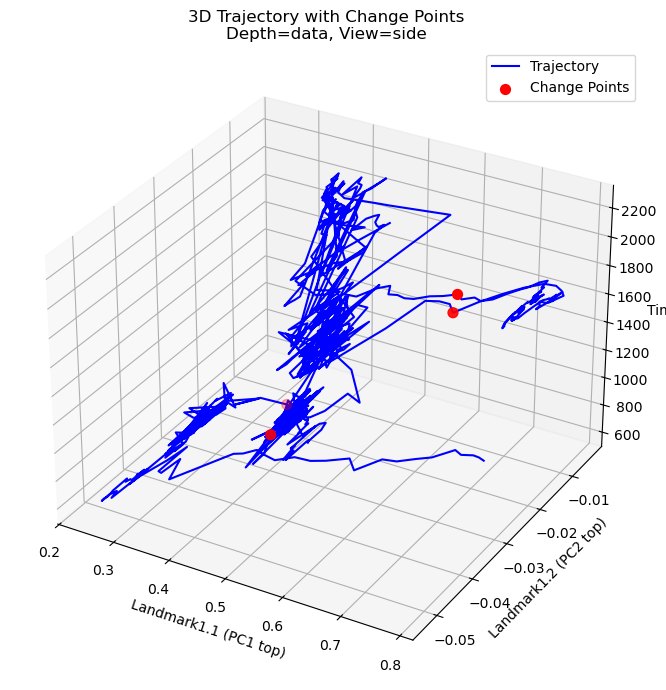

Change points (frame indices) for data side: [180, 405, 810, 965, 1265]


In [175]:
import ruptures as rpt

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

# Helper: get top feature for PC from top5_df DataFrame (which you created above)
def get_top_feature(top5_df, depth, view, component='PC1'):
    subset = top5_df[(top5_df['depth'] == depth) & (top5_df['view'] == view) & (top5_df['component'] == component)]
    print(subset)
    if subset.empty:
        return None
    return subset.iloc[0]['feature_1']  # the top feature is in feature_1 column

# Loop through unique depths and views from pca1_df or explained_df
depths = explained_df['depth'].unique()
views = explained_df['view'].unique()

for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_pc2_df, depth, view, 'PC2')

        print(top_feature_pc2)

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else '1')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = cleaned_df['frame_number'].to_numpy()

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)


        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # 3D Line Plot of the Trajectory
        ax.plot(x, y, t, label='Trajectory', color='blue')

        # Plot change points as red scatter points
        cp_x = [x[i] for i in change_points[:-1]]  # exclude last if it's just the end
        cp_y = [y[i] for i in change_points[:-1]]
        cp_t = [t[i] for i in change_points[:-1]]
        ax.scatter(cp_x, cp_y, cp_t, color='red', s=50, label='Change Points')

        # Labels and title
        ax.set_xlabel(f"{top_feature_pc1} (PC1 top)")
        ax.set_ylabel(f"{top_feature_pc2} (PC2 top)")
        ax.set_zlabel("Time")
        ax.set_title(f"3D Trajectory with Change Points\nDepth={depth}, View={view}")
        ax.legend()

        plt.tight_layout()
        plt.show()




        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")


## Shows change points on 2D graph --> creates new df for indices


Processing depth=data, view=side
  depth  view component    feature_1  weight_1    feature_2  weight_2  \
0  data  side       PC1  Landmark1.1  0.170074  Landmark2.1     0.169   

     feature_3  weight_3    feature_4  weight_4    feature_5  weight_5  
0  Landmark0.1  0.168659  Landmark7.1  0.166872  Landmark6.1  0.165833  
  depth  view component    feature_1  weight_1    feature_2  weight_2  \
0  data  side       PC2  Landmark1.2  0.183852  Landmark2.2  0.183852   

     feature_3  weight_3    feature_4  weight_4    feature_5  weight_5  
0  Landmark3.2  0.183852  Landmark4.2  0.183852  Landmark5.2  0.183852  


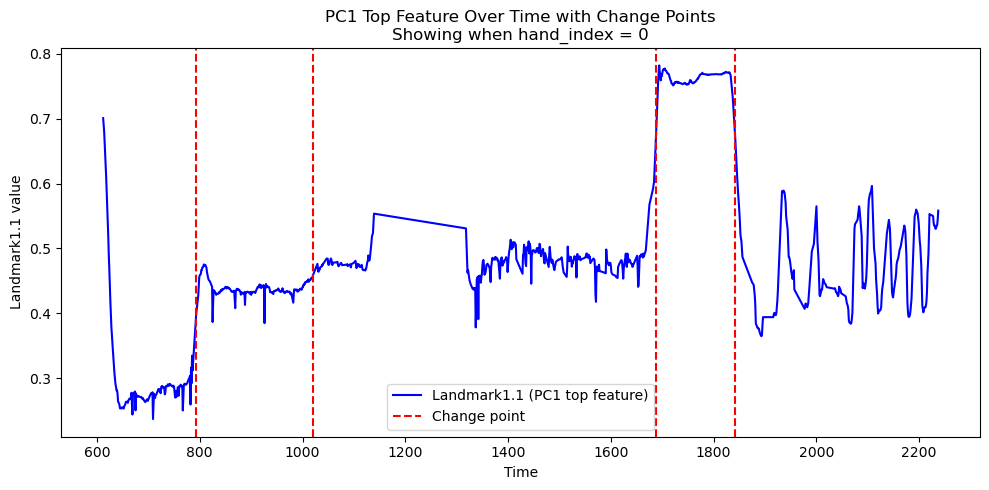

Change points (frame indices) for data side: [180, 405, 810, 965, 1265]


In [176]:
results_list = []

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_pc2_df, depth, view, 'PC2')

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else '1')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = cleaned_df['frame_number'].to_numpy()

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)



        # Inside the nested loop after change_points are computed
        plt.figure(figsize=(10, 5))
        plt.plot(t, x, label=f"{top_feature_pc1} (PC1 top feature)", color='blue')
        for cp in change_points[:-1]:  # Skip the last point if it's just the end of signal
            cp_frame = t[cp]  # Map change point index to actual frame number
            plt.axvline(x=cp_frame, color='red', linestyle='--', label='Change point' if cp == change_points[0] else "")

        plt.xlabel("Time")
        plt.ylabel(f"{top_feature_pc1} value")
        plt.title(f"PC1 Top Feature Over Time with Change Points\nShowing when hand_index = 0")
        plt.legend()
        plt.tight_layout()
        plt.show()




        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")

        # Create a dictionary for storing change point results
        dic_indices = {
            "depth": depth,
            "view": view,
            "component": "indices"
        }

        # Save the top features and their change points
        dic_indices["feature_1"] = top_feature_pc1
        dic_indices["feature_2"] = top_feature_pc2
        dic_indices["change_points"] = change_points

        # Assuming you're collecting multiple such dictionaries into a list
        results_list.append(dic_indices)





## Visualize indices df

In [177]:
df_indices = pd.DataFrame(results_list)

df_indices 

depth  view component    feature_1    feature_2               change_points
0  data  side   indices  Landmark1.1  Landmark1.2  [180, 405, 810, 965, 1265]

## Averaging close datapoints

In [181]:
# Create an empty list to hold averaged points for each row
averaged_points_list = []

# Loop through each row in the DataFrame
for _, row in df_indices.iterrows():
    change_points = row['change_points']
    averaged_points = average_close_indices(change_points, threshold=100)
    averaged_points_list.append(averaged_points)

# Assign the results as a new column in the DataFrame
df_indices['averaged_points'] = averaged_points_list

## Creating movement df for armEF

In [182]:
df_movements = pd.DataFrame(columns=['dataset', 'view', 'arm_EF', 'hand_OC', 'hand_PS'])

for _, row in df_indices.iterrows():
    all_indices = row['averaged_points']
    movement = 'arm_EF'

    if len(all_indices) == 1:
        continue

    dif = all_indices[-2] - all_indices[-1]
    print(f'the difference is {dif}')

    if np.abs(all_indices[-2] - all_indices[-1]) < 250:
        if len(all_indices) >= 3:
            start = all_indices[-3]
            end = all_indices[-2]
        else: 
            start = all_indices[-2]
            end = all_indices[-1]
    else:
        start = all_indices[-2]
        end = all_indices[-1]
        

    df_movements = pd.concat([
    df_movements,
    pd.DataFrame([{
        'dataset': row['depth'],        # <- use `row` to access data from df_indices
        'view': row['view'],
        'arm_EF': (start, end),
        'hand_OC': (0,0),
        'hand_PS': (0,0)
    }])
], ignore_index=True)

print(df_movements)

the difference is -300
  dataset  view       arm_EF hand_OC hand_PS
0    data  side  (965, 1265)  (0, 0)  (0, 0)


## Visualizing armEF segmentation

KeyError: 'indices'

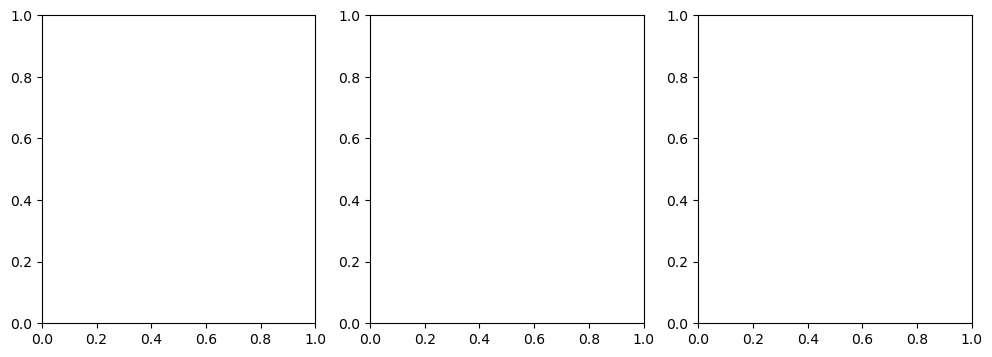

In [183]:
import matplotlib.pyplot as plt
import math

# Filter out rows where depth is 't1'
filtered_movements = df_movements[df_movements['dataset'] != 't1']
n = len(filtered_movements)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=True)
axs = axs.flatten()

for idx, (i, row) in enumerate(filtered_movements.iterrows()):
    depth = row['dataset']
    view_type = row['view']
    start, end = row['indices']

    df_key = depth + ('f' if view_type == 'front' else 's')
    if df_key not in dataframes:
        print(f"Data for {df_key} not found.")
        continue

    df = dataframes[df_key]

    top_feature = get_top_feature(top5_pc1_df, depth, view_type, 'PC1')
    if top_feature not in df.columns:
        print(f"{top_feature} not found in data for {df_key}")
        continue

    segment = df[top_feature].iloc[start:end+1]

    ax = axs[idx]
    ax.plot(segment.index, segment.values)
    ax.set_title(f"{depth} {view_type} segment {i}")
    ax.set_ylabel(f"{top_feature}")
    ax.grid(True)

# Hide any unused subplots
for i in range(n, len(axs)):
    fig.delaxes(axs[i])

plt.xlabel("Time (Index)")
plt.tight_layout()
plt.show()


## Run PCA on only handOC and handPS time - working on now

In [187]:
# New containers for start-segment PCA data
pca1_start_rows = []
pca2_start_rows = []
explained_start_rows = []
top5_start_pc1_rows = []
top5_start_pc2_rows = []

view_map = {"front": "f", "side": "s"}

for _, row in df_movements.iterrows():
    depth = row["dataset"]
    view = row["view"]

    # Skip if missing
    if pd.isna(depth) or pd.isna(view):
        continue

    # Map "front"/"side" to "f"/"s"
    view_letter = view_map.get(view.lower())

    if view_letter is None:
        print(f"Unrecognized view: {view}")
        continue

    base = f"{depth}{1}"

    if base not in dataframes:
        print(f"Skipping {base} - not found in dataframes.")
        continue

    df_full = dataframes[base]
    


    # Get starting segment: from 0 to first change point of armEF so it only includes handOC and armPS
    change_points = row['arm_EF']  
    if not change_points or len(change_points) == 0:
        continue  # Skip if no change points
    
    first_cp = int(change_points[0])
    df_segment = df_full.iloc[:first_cp]

    # Trim initial zeros like before
    df_trimmed = trim_initial_zeros(df_segment)

    # Run PCA on start segment
    X_pca, explained_ratio, explained_raw, components = run_PCA(df_segment, None, base, "start")

    used_columns = df_segment.loc[:, ~df_segment.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    pc1 = components[0]
    pc2 = components[1]

    # Build PCA1 row
    row_pc1 = {"depth": depth, "view": view_letter, "component": "PC1"}
    row_pc2 = {"depth": depth, "view": view_letter, "component": "PC2"}
    
    for feat, w1, w2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = w1
        row_pc2[feat] = w2

    pca1_start_rows.append(row_pc1)
    pca2_start_rows.append(row_pc2)

    explained_start_rows.append({
        "depth": depth,
        "view": view_letter,
        "PC1_var": explained_ratio[0],
        "PC2_var": explained_ratio[1]
    })

    # Top 5 for PC1
    contributions = list(zip(final_cols, pc1))
    contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    top5 = contributions[:5]

    top5_dict = {
        "depth": depth,
        "view": view,
        "component": "PC1"
    }
    for idx, (feat, weight) in enumerate(top5):
        top5_dict[f"feature_{idx+1}"] = feat
        top5_dict[f"weight_{idx+1}"] = weight
    top5_start_pc1_rows.append(top5_dict)


    # Top 5 for PC2
    contributions_pc2 = list(zip(final_cols, pc2))
    contributions_pc2.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc2 = contributions_pc2[:5]

    top5_dict_pc2 = {
        "depth": depth,
        "view": view,
        "component": "PC2"
    }
    for idx, (feat, weight) in enumerate(top5_pc2):
        top5_dict_pc2[f"feature_{idx+1}"] = feat
        top5_dict_pc2[f"weight_{idx+1}"] = weight
    top5_start_pc2_rows.append(top5_dict_pc2)


# At the end: convert to dataframes
pca1_start_df = pd.DataFrame(pca1_start_rows)
pca2_start_df = pd.DataFrame(pca2_start_rows)
explained_start_df = pd.DataFrame(explained_start_rows)
top5_start_pc1_df = pd.DataFrame(top5_start_pc1_rows)
top5_start_pc2_df = pd.DataFrame(top5_start_pc2_rows)



In [188]:
top5_start_pc1_df

depth  view component    feature_1  weight_1    feature_2  weight_2  \
0  data  side       PC1  Landmark1.1  0.166968  Landmark0.1  0.166795   

     feature_3  weight_3     feature_4  weight_4     feature_5  weight_5  
0  Landmark2.1  0.165592  Landmark11.1   0.16441  Landmark15.1  0.164249

## Runs Ruptures on the handOC and handPS


Processing depth=data, view=1
  depth  view component    feature_1  weight_1    feature_2  weight_2  \
0  data  side       PC1  Landmark1.1  0.166968  Landmark0.1  0.166795   

     feature_3  weight_3     feature_4  weight_4     feature_5  weight_5  
0  Landmark2.1  0.165592  Landmark11.1   0.16441  Landmark15.1  0.164249  
  depth  view component         feature_1  weight_1        feature_2  \
0  data  side       PC2  Landmark20_score  0.213818  Landmark0_score   

   weight_2        feature_3  weight_3        feature_4  weight_4  \
0  0.213818  Landmark2_score  0.213818  Landmark3_score  0.213818   

         feature_5  weight_5  
0  Landmark4_score  0.213818  


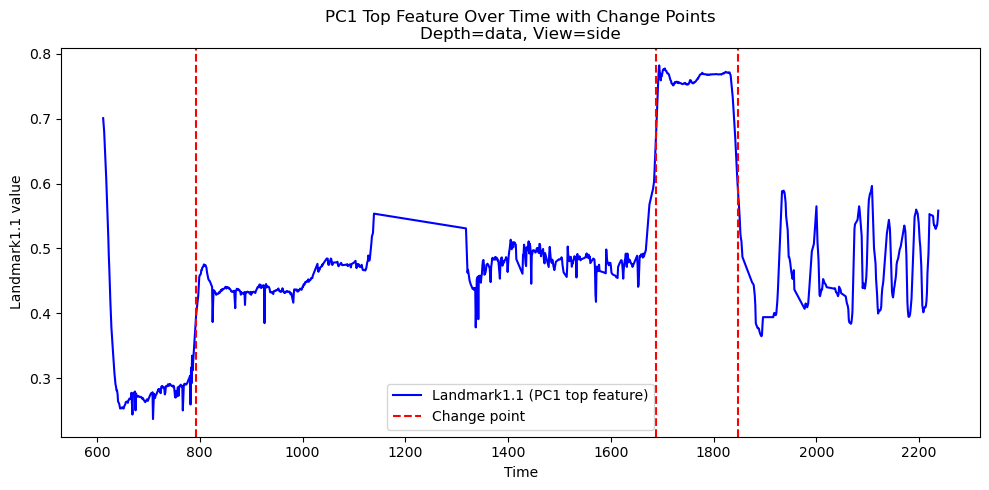

Change points (frame indices) for data side: [180, 810, 970, 1265]


depth  view component    feature_1         feature_2          change_points
0  data  side   indices  Landmark1.1  Landmark20_score  [180, 810, 970, 1265]

In [195]:
results_list2 = []

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

# creates new column for new change points
if 'cp_handOC_handPS' not in df_indices.columns:
    df_indices['cp_handOC_handPS'] = None
    df_indices['cp_handOC_handPS'] = df_indices['cp_handOC_handPS'].astype(object)


for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={1}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_start_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_start_pc2_df, depth, view, 'PC2')

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else '1')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = cleaned_df['frame_number'].to_numpy()

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)



        # Inside the nested loop after change_points are computed
        plt.figure(figsize=(10, 5))
        plt.plot(t, x, label=f"{top_feature_pc1} (PC1 top feature)", color='blue')
        for cp in change_points[:-1]:  # Skip the last point if it's just the end of signal
            cp_frame = t[cp]  # Map change point index to actual frame number
            plt.axvline(x=cp_frame, color='red', linestyle='--', label='Change point' if cp == change_points[0] else "")
        plt.xlabel("Time")
        plt.ylabel(f"{top_feature_pc1} value")
        plt.title(f"PC1 Top Feature Over Time with Change Points\nDepth={depth}, View={view}")
        plt.legend()
        plt.tight_layout()
        plt.show()




        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")

        # Create a dictionary for storing change point results
        dic_indices2 = {
            "depth": depth,
            "view": view,
            "component": "indices"
        }

        # Save the top features and their change points
        dic_indices2["feature_1"] = top_feature_pc1
        dic_indices2["feature_2"] = top_feature_pc2
        dic_indices2["change_points"] = change_points

        # Assuming you're collecting multiple such dictionaries into a list
        results_list2.append(dic_indices2)

df_indices2 = pd.DataFrame(results_list2)

df_indices2 


## Segment

In [ ]:
# run through df_movements, df_indices, df_indices2 at the same time

    # set armEF_start = indice[0] from df_movement
    # cp_list_beg = indices/cp from the df_indices2
    # cp_list_all = cp from 

    # get rid of any points in the lists that are equal or after the arm_EF_start

    # average the points within 100 of one another within cp_list_beg

    # compare the points to the ruptures of the overall PCA
    # so compare cp_list_beg and cp_list_all

    # graph the points in common and the armEF segment
    # create new list of points in common of within 100 of each other from the two lists as well as the indices from the armEF indices one from df_movements and then i want to graph it on the 
    # x = df[top_feature_pc1].to_numpy() 

In [190]:
print(df_movements)


  dataset  view       arm_EF hand_OC hand_PS
0    data  side  (965, 1265)  (0, 0)  (0, 0)


[280, 585, 710, 1270, 1331]
[475, 715, 1265, 1331]


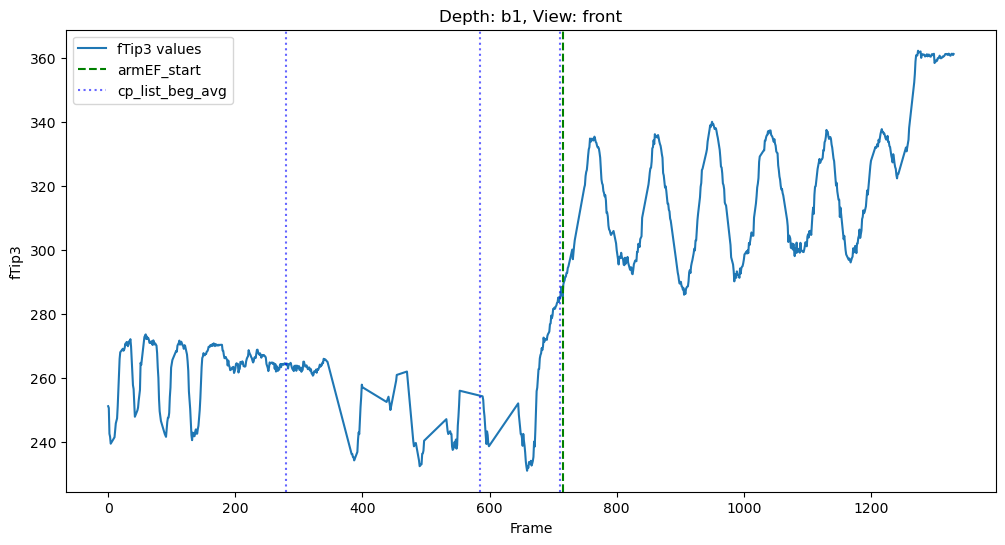

[350, 505, 715, 1270, 1317]
[480, 720, 1265, 1317]


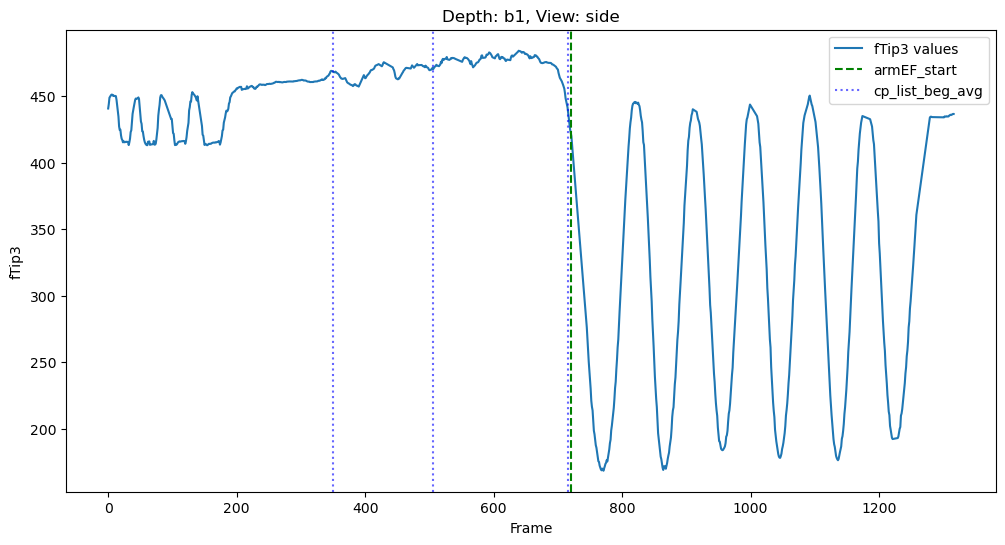

[135, 535, 915, 1361]
[140, 560, 845, 1361]


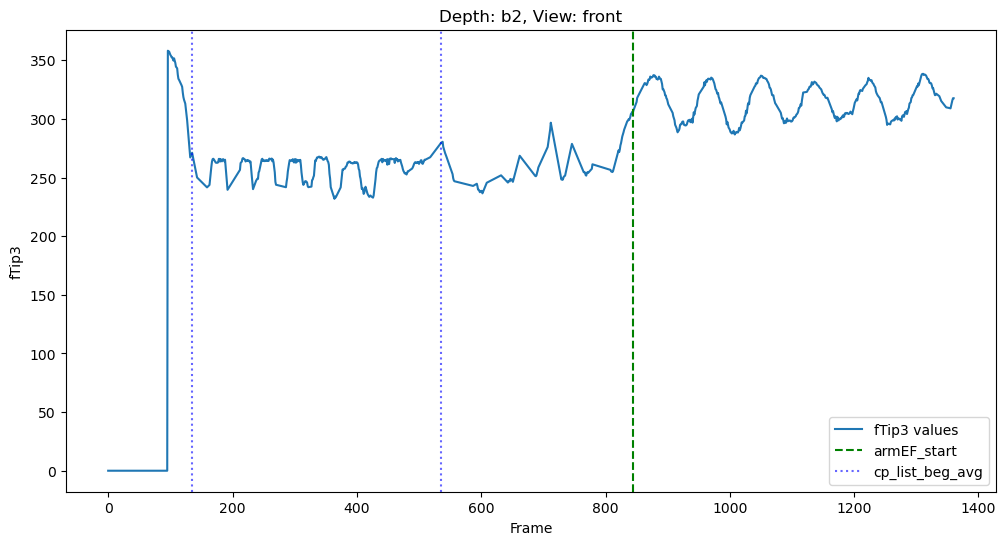

[135, 525, 845, 1364]
[130, 540, 845, 1364]


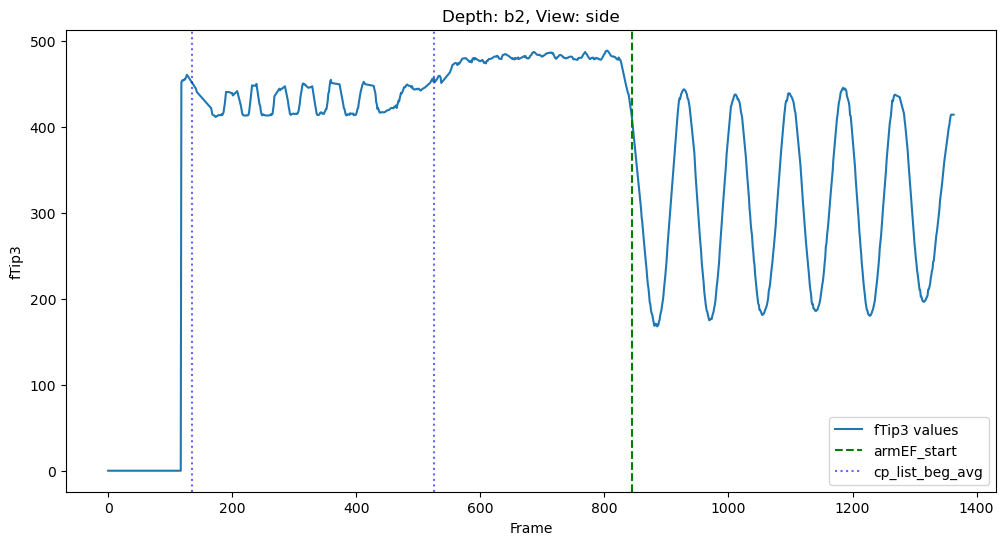

[310, 625, 1085, 1181]
[230, 615, 1135, 1181]


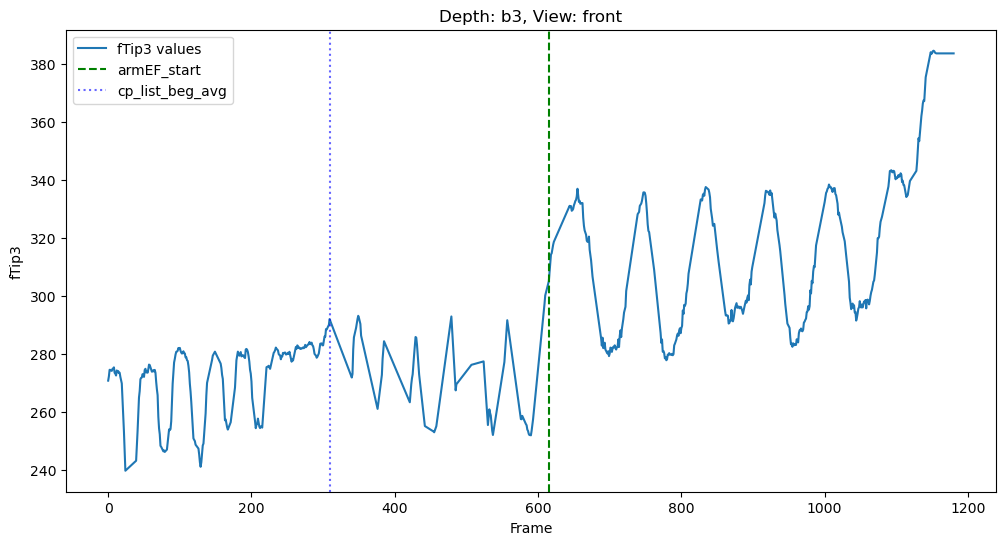

[310, 610, 1135, 1220]
[620, 1135, 1220]


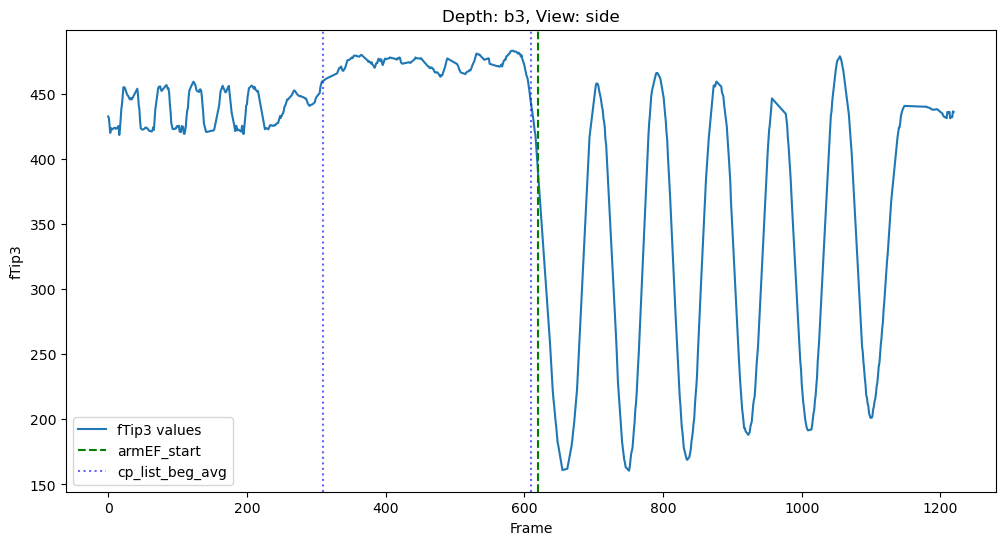

[475, 625, 1000, 1195, 1777]
[475, 625, 1000, 1195, 1777]


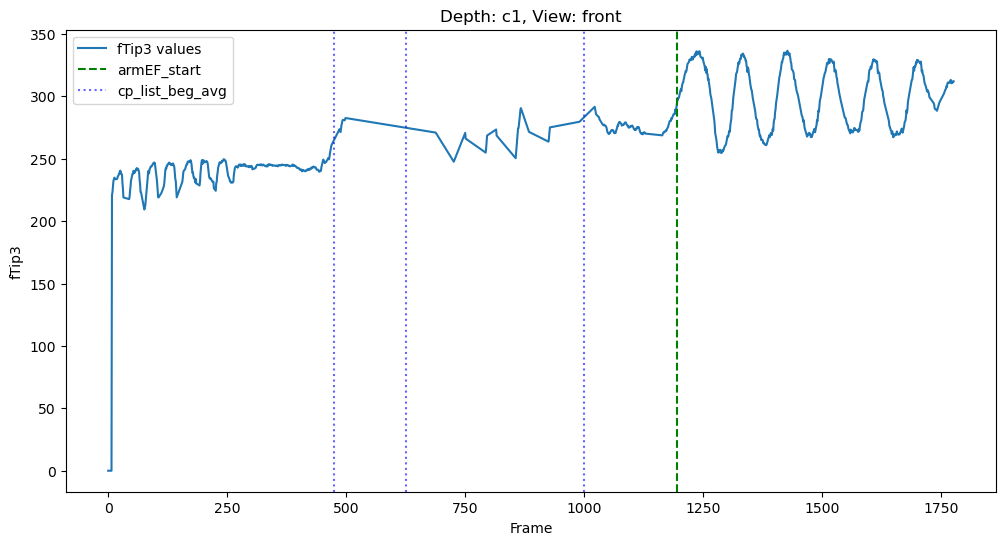

[510, 1005, 1195, 1751]
[495, 1015, 1200, 1751]


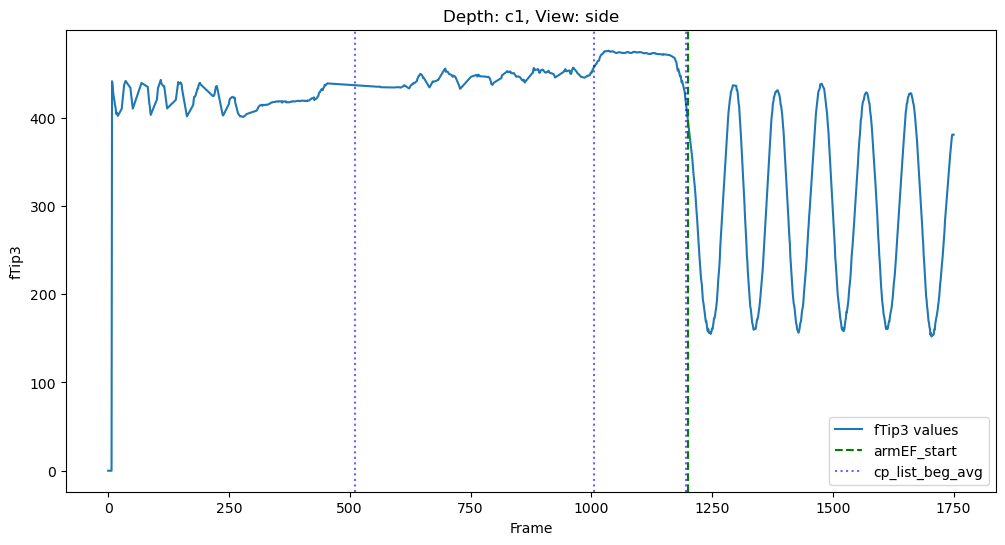

[190, 230, 640, 810, 1265, 1842]
[190, 235, 645, 800, 1260, 1842]


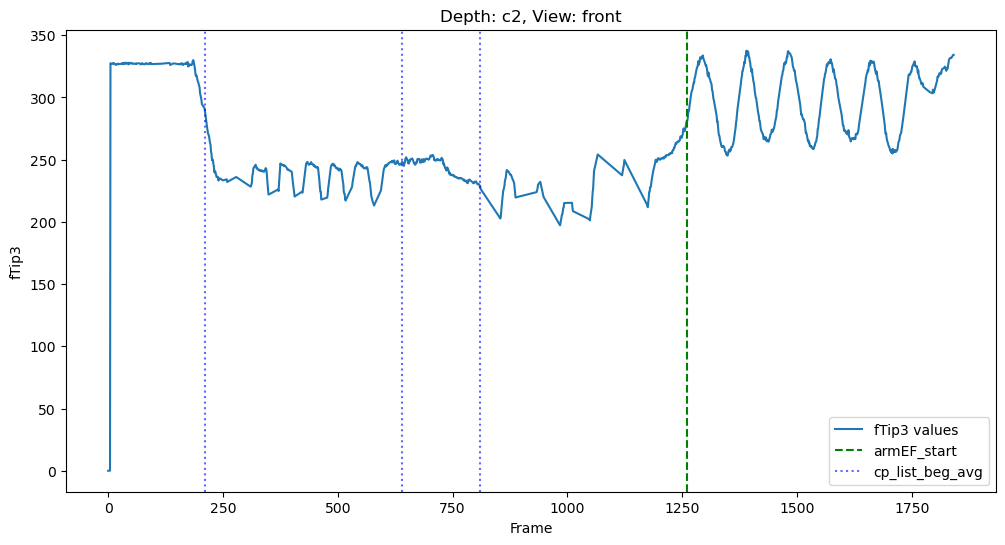

[195, 270, 650, 1255, 1820, 1874]
[170, 225, 655, 1260, 1805, 1874]


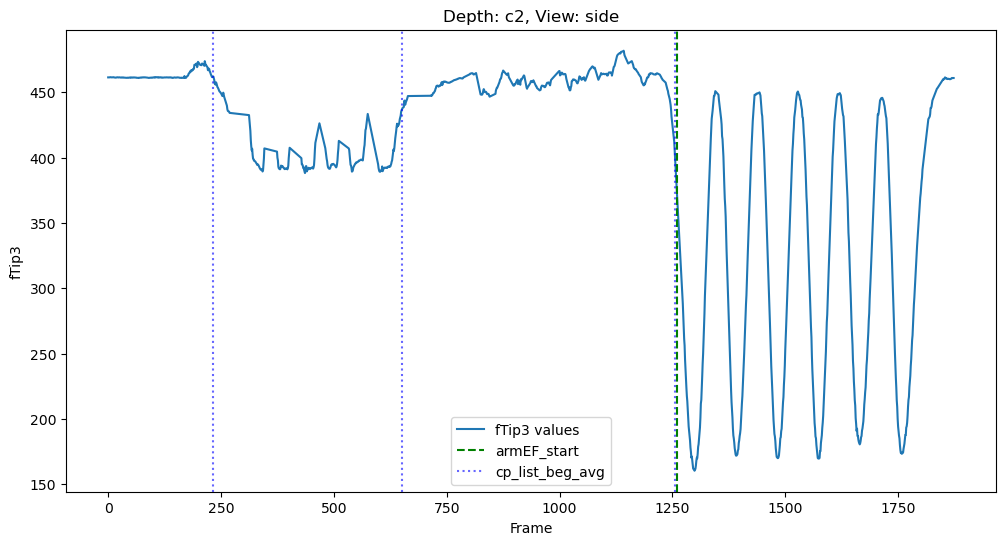

[150, 200, 570, 1075, 1653]
[160, 200, 1085, 1653]


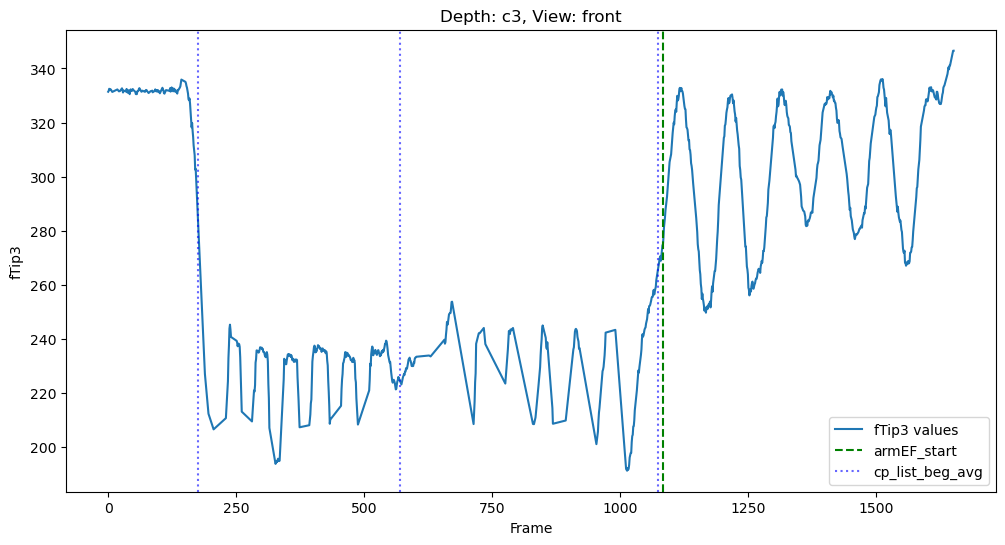

[185, 555, 1075, 1637]
[130, 180, 1080, 1637]


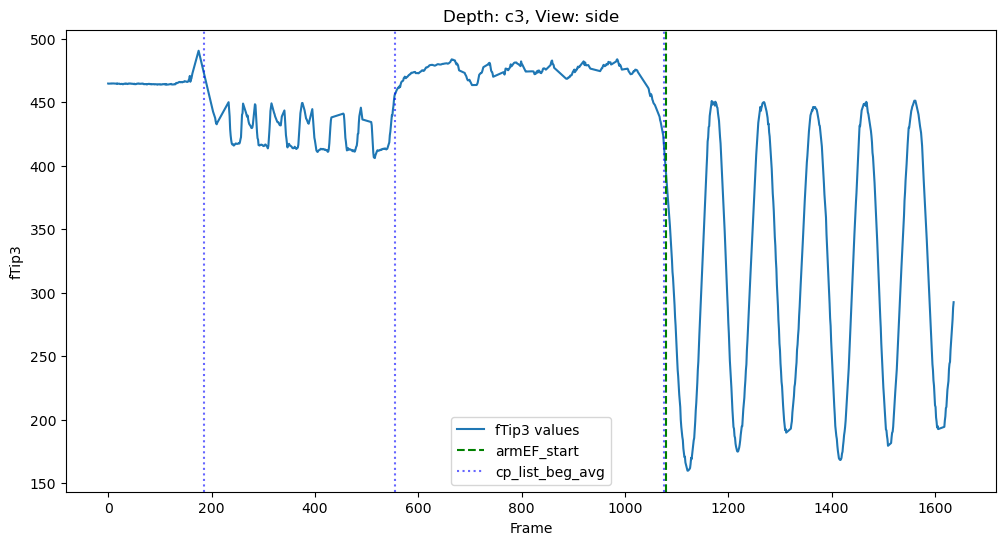

[115, 1265, 1430, 2000, 2485, 2805]
[115, 1270, 1425, 1995, 2485, 2805]


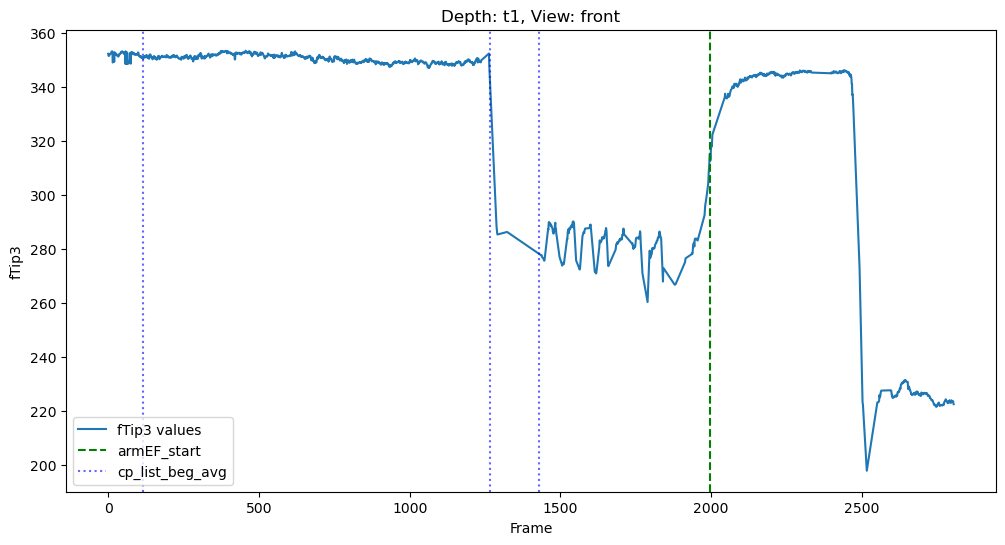

[1295, 2000, 2335, 2495, 3500, 3940, 4120, 4190, 4270, 4340, 4430, 4500, 4570, 4635, 4710, 4795, 5474]
[1260, 1990, 2365, 2545, 2735, 3010, 3535, 3640, 3890, 3960, 4725, 4775, 5474]


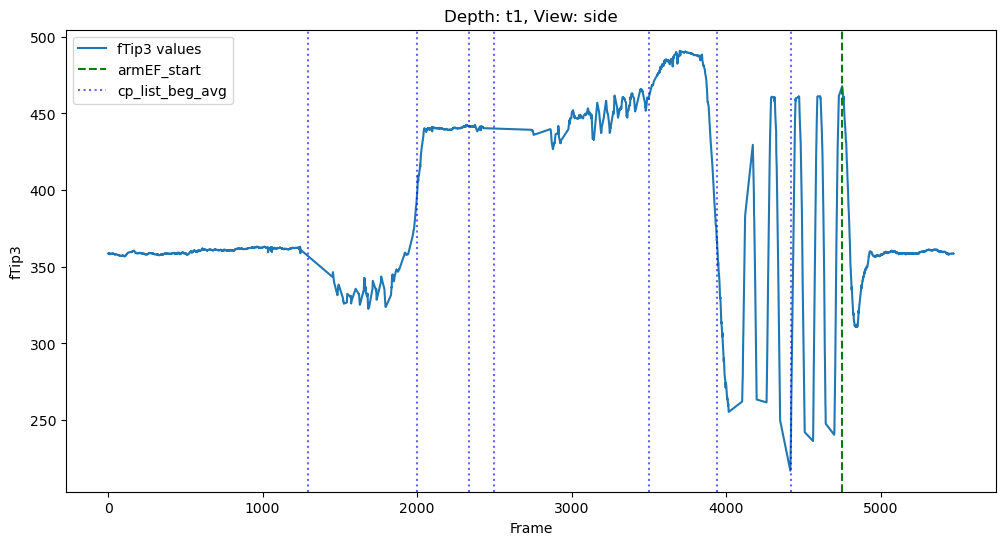

[440, 990, 1200, 1665, 1985, 2760, 2810, 3131]
[455, 1005, 1210, 1650, 2025, 2760, 3131]


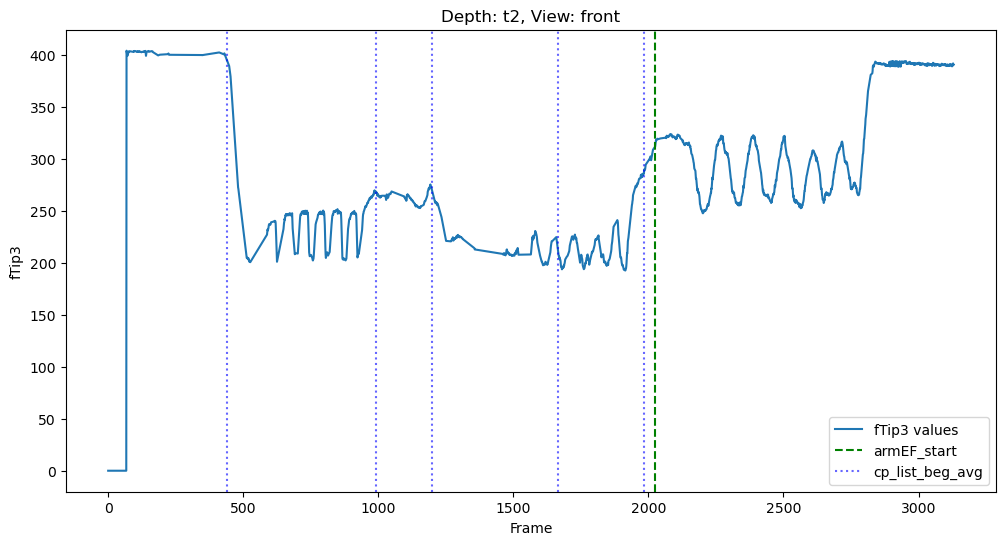

[460, 1000, 1210, 1590, 2010, 2065, 2160, 2755, 3138]
[465, 1015, 1205, 1665, 2020, 2075, 2155, 2755, 3138]


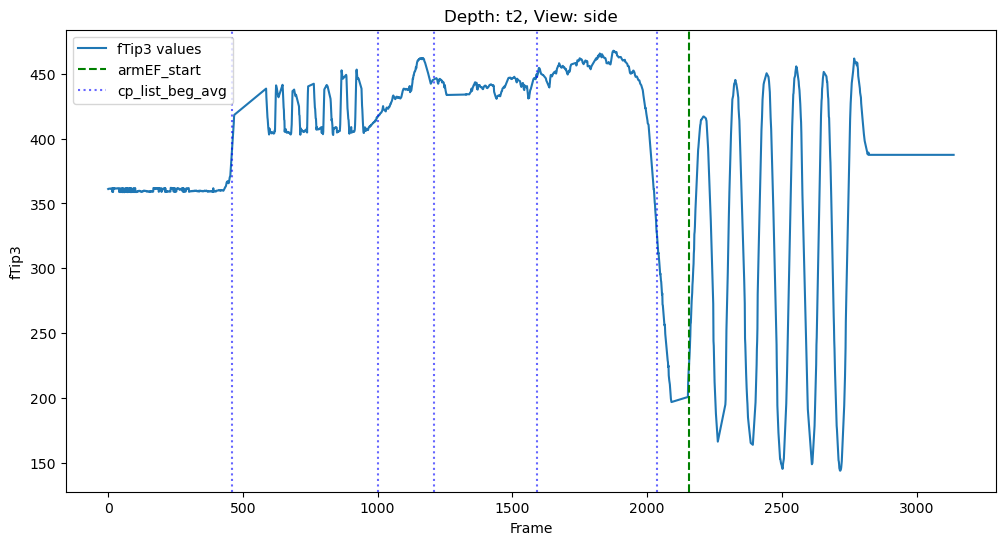

[55, 435, 1125, 1670, 2375, 2758]
[385, 435, 1140, 1665, 2330, 2370, 2758]


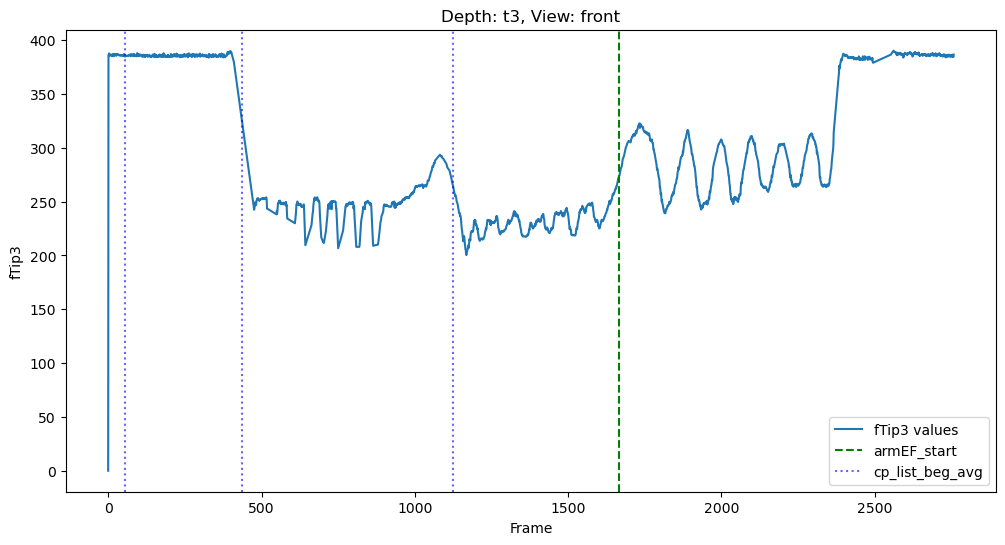

[415, 1675, 2335, 2777]
[415, 1675, 2340, 2777]


In [387]:
import numpy as np
import matplotlib.pyplot as plt

def average_close_points(points, threshold=100):
    """Average points that are within threshold of each other."""
    points = sorted(points)
    averaged = []
    cluster = [points[0]]
    for p in points[1:]:
        if p - cluster[-1] <= threshold:
            cluster.append(p)
        else:
            averaged.append(int(np.mean(cluster)))
            cluster = [p]
    averaged.append(int(np.mean(cluster)))
    return averaged

for idx, (depth, view) in enumerate(zip(df_movements['dataset'], df_movements['view'])):
    
    armEF_start = df_movements.iloc[idx]['arm_EF'][0]  # First value of the tuple

    
    # Get cp lists from df_indices2 and df_indices (or wherever cp_list_all is)
    cp_list_beg = df_indices2.loc[
        (df_indices2['depth'] == depth) & (df_indices2['view'] == view), 'change_points'
    ].values
    if len(cp_list_beg) == 0:
        continue
    cp_list_beg = cp_list_beg[0]  # assuming it's a list stored in a cell

    print(cp_list_beg)
    
    cp_list_all = df_indices.loc[
        (df_indices['depth'] == depth) & (df_indices['view'] == view), 'change_points'
    ].values
    if len(cp_list_all) == 0:
        continue
    cp_list_all = cp_list_all[0]  # assuming list stored in cell

    print(cp_list_all)
    
    # Remove points >= armEF_start
    cp_list_beg_filtered = [pt for pt in cp_list_beg if pt < armEF_start]
    cp_list_all_filtered = [pt for pt in cp_list_all if pt < armEF_start]
    
    # Average points within 100 in cp_list_beg
    cp_list_beg_avg = average_close_points(cp_list_beg_filtered, threshold=100)

    # Find the row index in df_movements for the current depth and view
    row_idx = df_movements[
        (df_movements['dataset'] == depth) & 
        (df_movements['view'] == view)
    ].index

    if not row_idx.empty:
        row_idx = row_idx[0]  # Get the actual index value

        if cp_list_beg_avg[0] < 250:
            # Update hand_OC and hand_PS columns directly
            df_movements.at[row_idx, 'hand_OC'] = (cp_list_beg_avg[0], cp_list_beg_avg[1])
            df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[1], armEF_start)
        else:
            df_movements.at[row_idx, 'hand_OC'] = (0, cp_list_beg_avg[0])
            df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[0], armEF_start)

    else:
        print(f"Row not found for dataset={depth}, view={view}")


    
    # Find common points between cp_list_beg_avg and cp_list_all_filtered within 100 units
    common_points = []
    for pt1 in cp_list_beg_avg:
        for pt2 in cp_list_all_filtered:
            if abs(pt1 - pt2) <= 100:
                common_points.append(int((pt1 + pt2) / 2))
                break
                
    common_points = sorted(set(common_points))
    
    # Get your dataframe with top PC1 feature for this depth & view
    df_key = depth + ('f' if view == 'front' else 's')
    if df_key not in dataframes:
        print(f"Missing df for {df_key}")
        continue
    df = dataframes[df_key]
    
    x = df[top_feature_pc1].to_numpy()
    t = np.arange(len(x))
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(t, x, label=f"{top_feature_pc1} values")
    
    # Plot armEF_start as vertical line
    plt.axvline(armEF_start, color='green', linestyle='--', label='armEF_start')
    
    # Plot change points
    for cp in cp_list_beg_avg:
        plt.axvline(cp, color='blue', linestyle=':', alpha=0.6, label='cp_list_beg_avg' if cp == cp_list_beg_avg[0] else "")
    '''
    for cp in cp_list_all_filtered:
        plt.axvline(cp, color='orange', linestyle=':', alpha=0.6, label='cp_list_all_filtered' if cp == cp_list_all_filtered[0] else "")
    for cp in common_points:
        plt.axvline(cp, color='red', linestyle='-', linewidth=2, label='common_points' if cp == common_points[0] else "")

    '''
    
    plt.title(f"Depth: {depth}, View: {view}")
    plt.xlabel('Frame')
    plt.ylabel(f'{top_feature_pc1}')
    plt.legend()
    plt.show()


In [388]:
df_movements

dataset   view        arm_EF      hand_OC       hand_PS
0       b1  front   (715, 1298)     (0, 280)    (280, 715)
1       b1   side   (720, 1291)     (0, 350)    (350, 720)
2       b2  front   (845, 1361)   (135, 535)    (535, 845)
3       b2   side   (845, 1364)   (135, 525)    (525, 845)
4       b3  front   (615, 1158)     (0, 310)    (310, 615)
5       b3   side   (620, 1177)     (0, 310)    (310, 620)
6       c1  front  (1195, 1777)     (0, 475)   (475, 1195)
7       c1   side  (1200, 1751)     (0, 510)   (510, 1200)
8       c2  front  (1260, 1842)   (210, 640)   (640, 1260)
9       c2   side  (1260, 1839)   (232, 650)   (650, 1260)
10      c3  front  (1085, 1653)   (175, 570)   (570, 1085)
11      c3   side  (1080, 1637)   (185, 555)   (555, 1080)
12      t1  front  (1995, 2485)  (115, 1265)  (1265, 1995)
13      t1   side  (4750, 5474)    (0, 1295)  (1295, 4750)
14      t2  front  (2025, 2760)     (0, 440)   (440, 2025)
15      t2   side  (2155, 2755)     (0, 460)   (460, 2155)
16      t3  front  (1665, 2350)    (55, 435)   (435, 1665)
17      t3   side  (1675, 2340)     (0, 415)   (415, 1675)

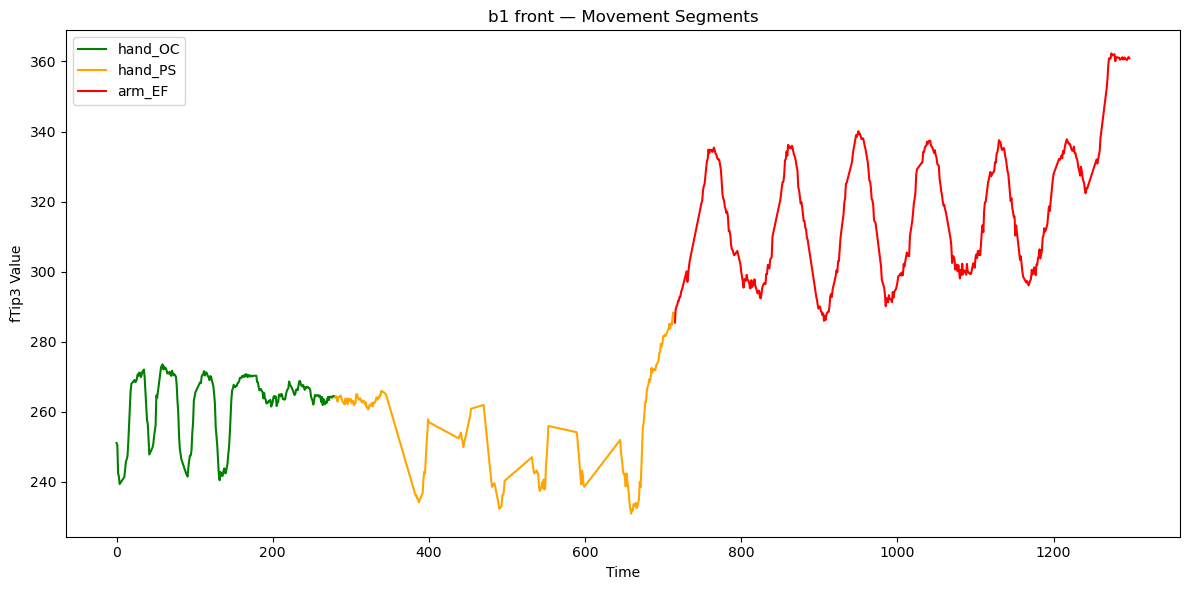

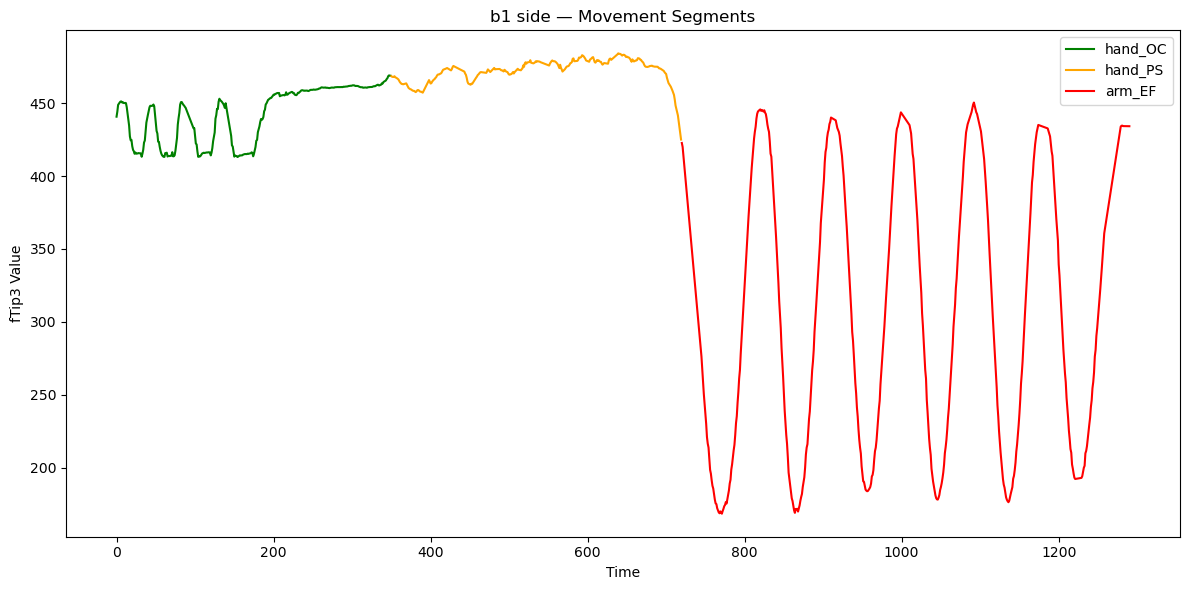

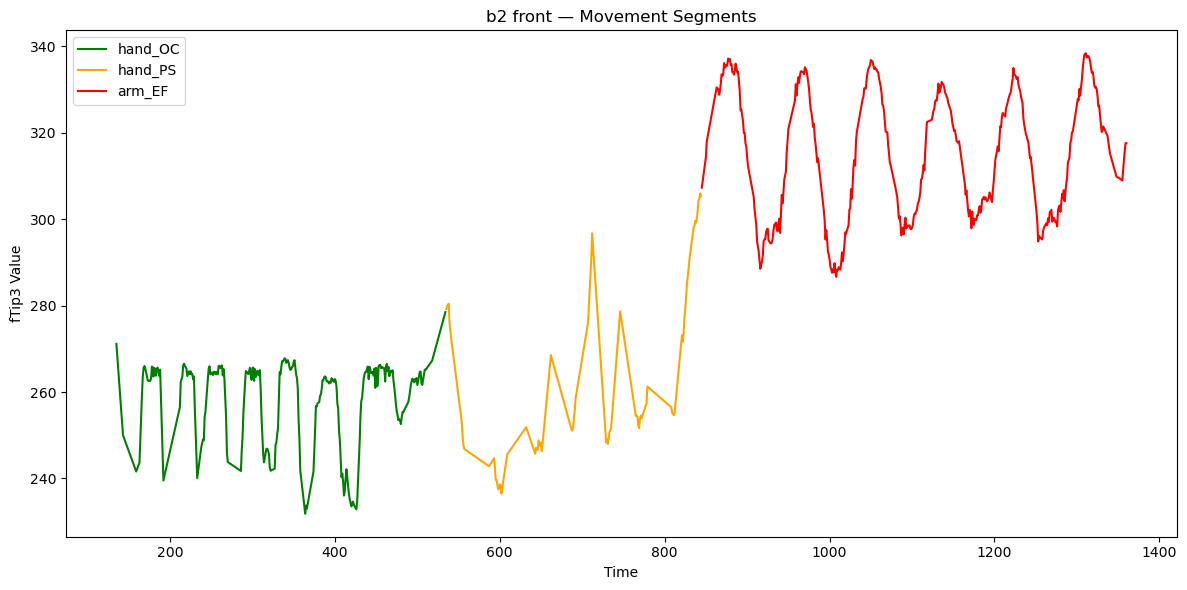

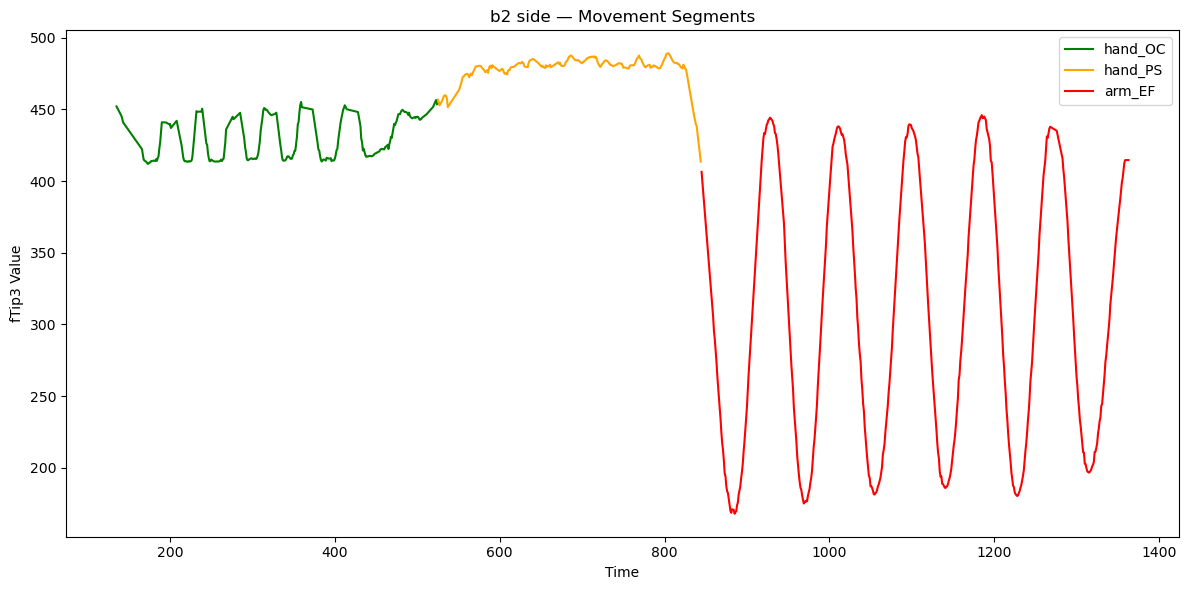

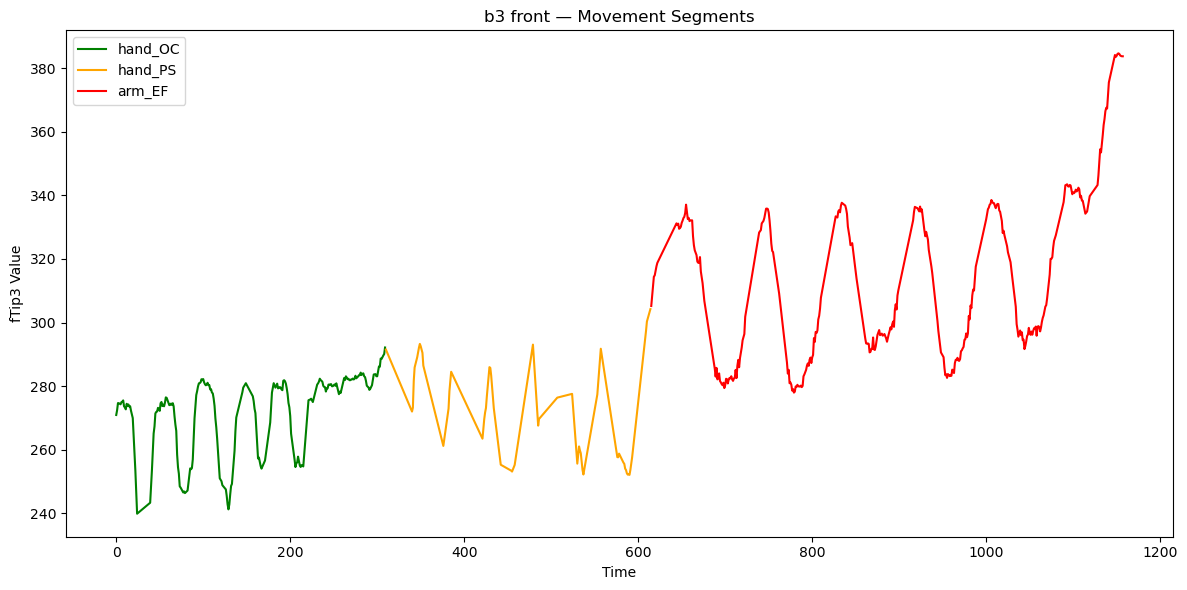

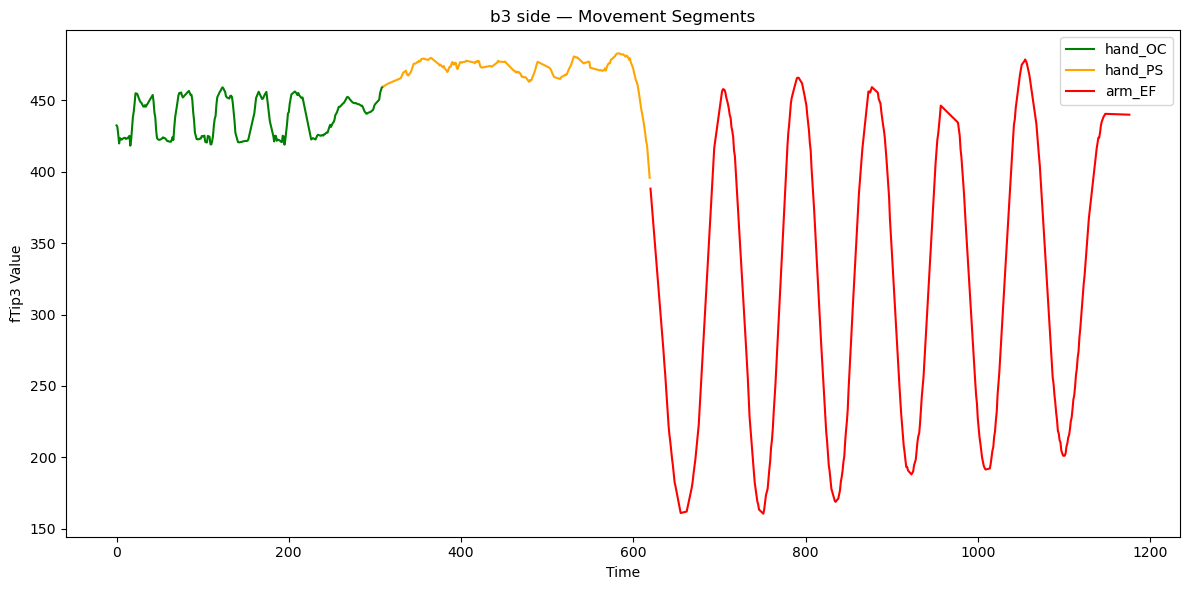

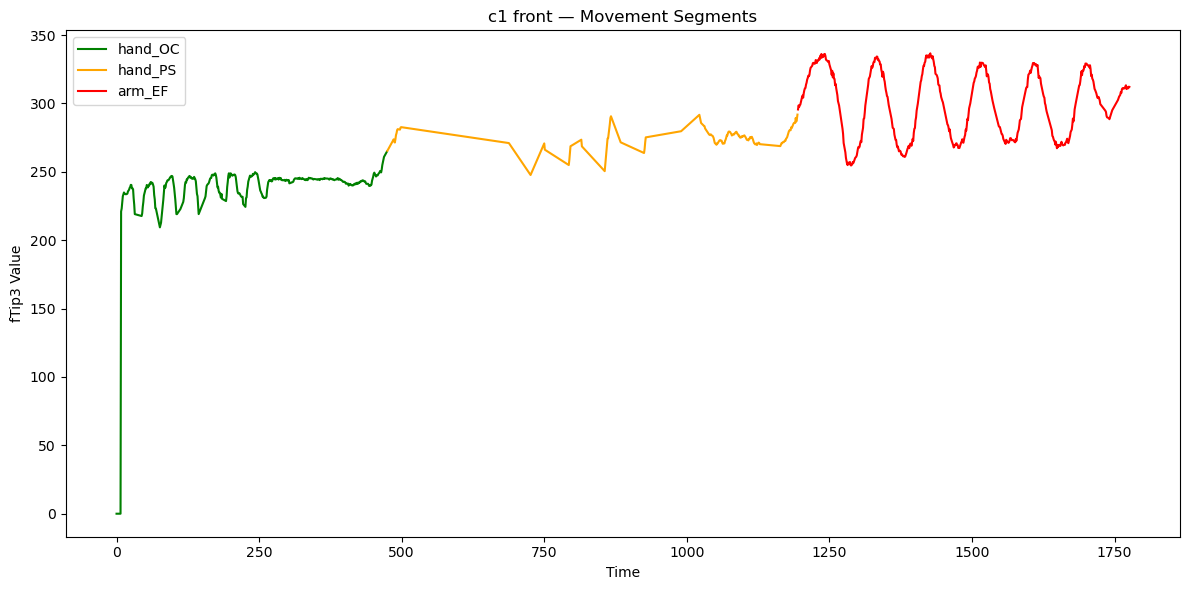

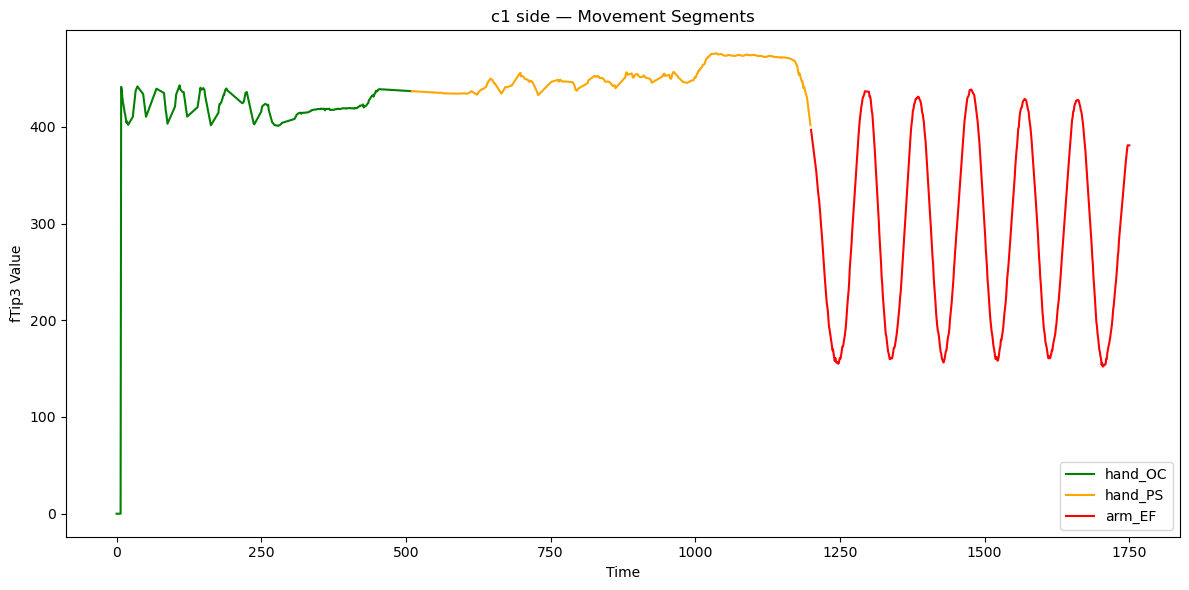

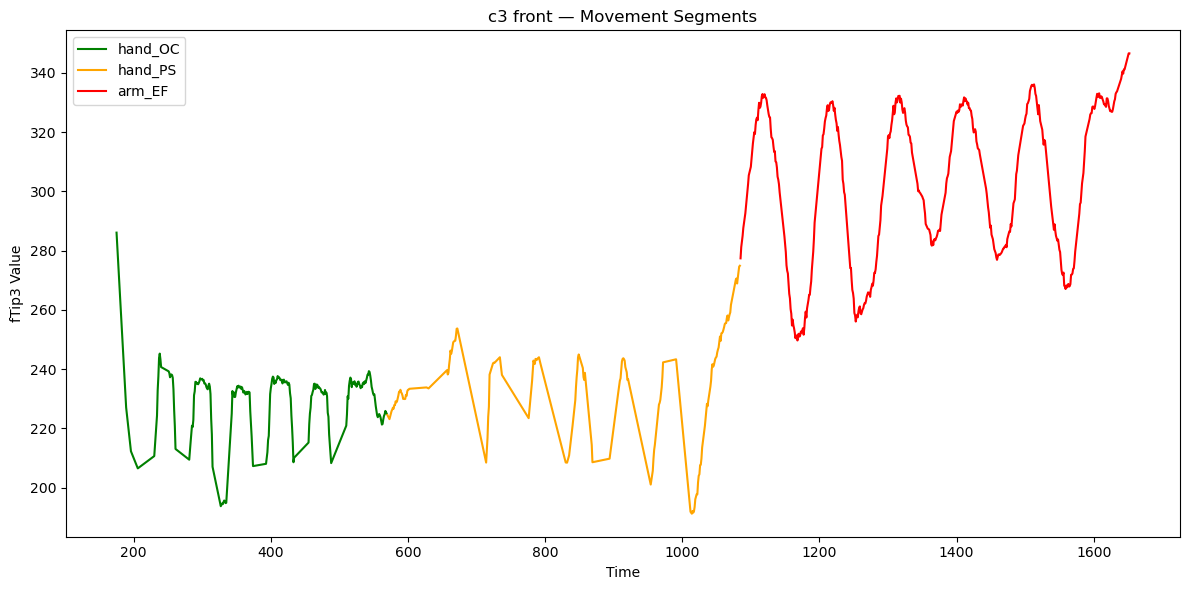

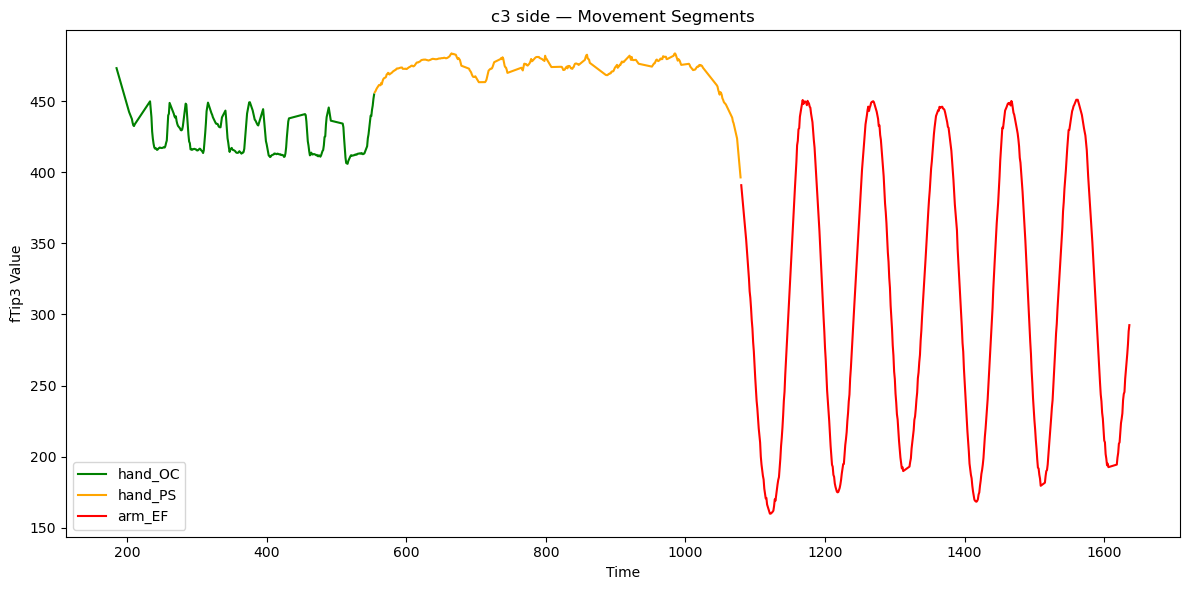

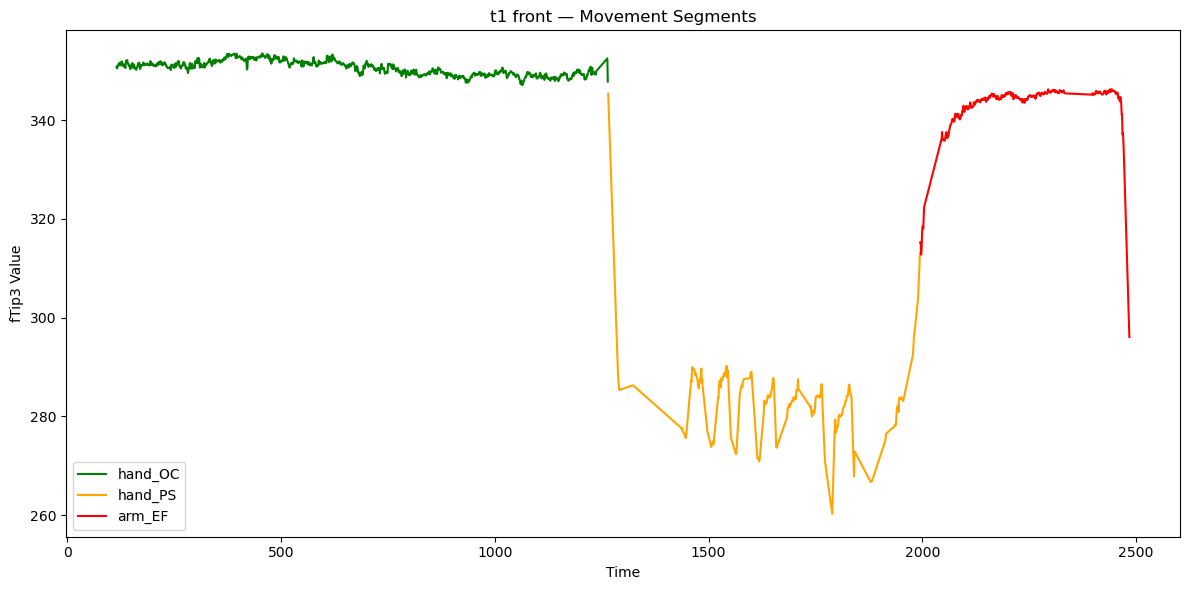

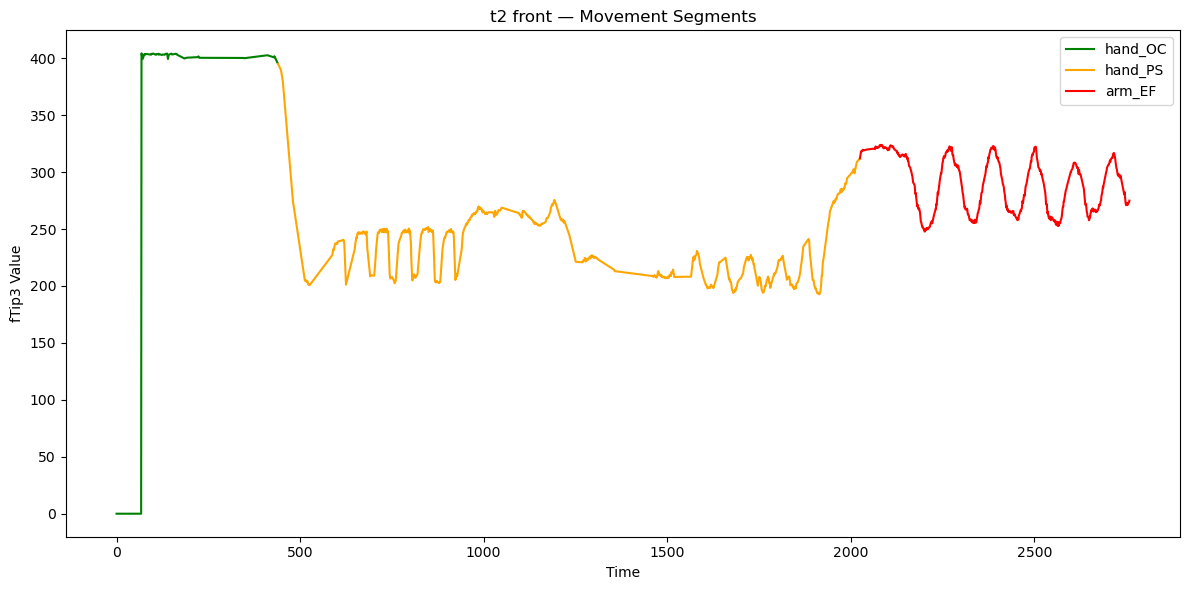

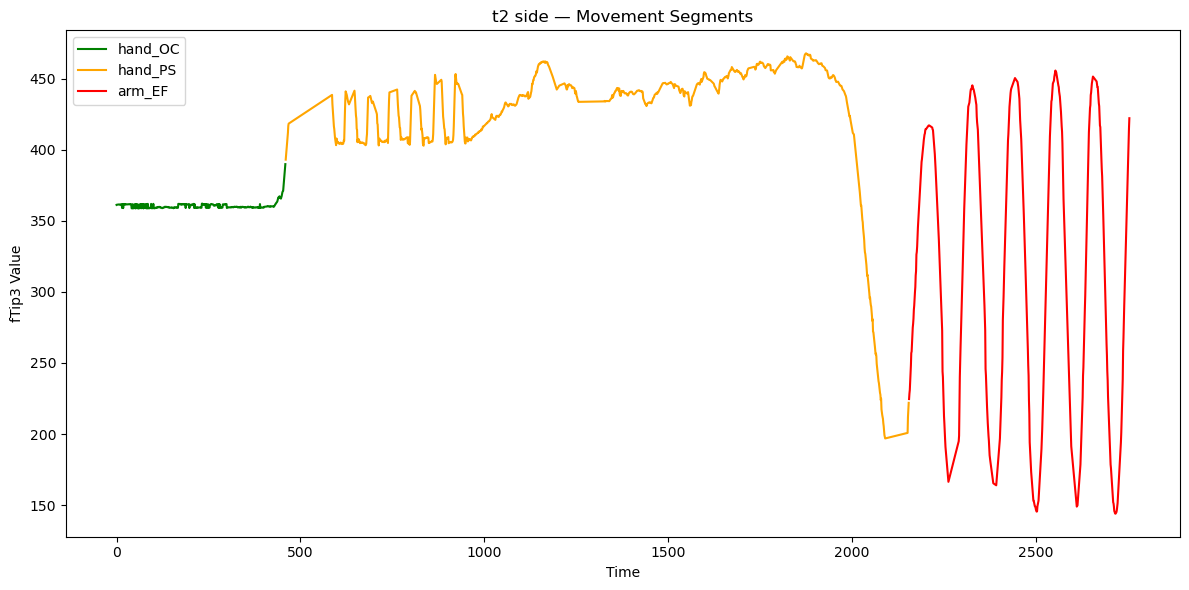

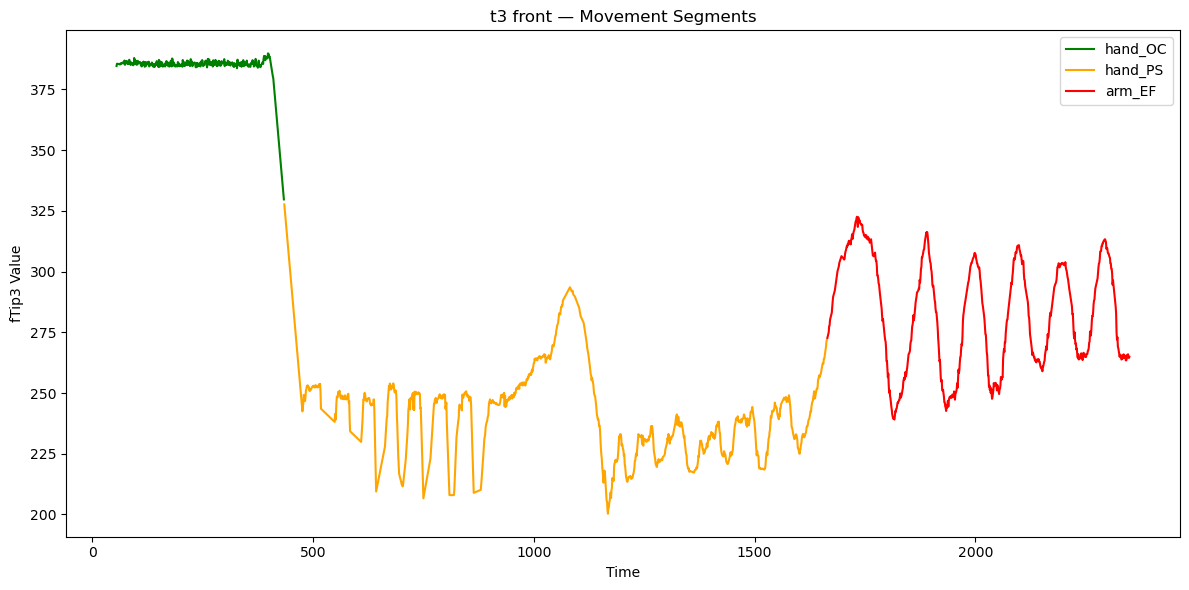

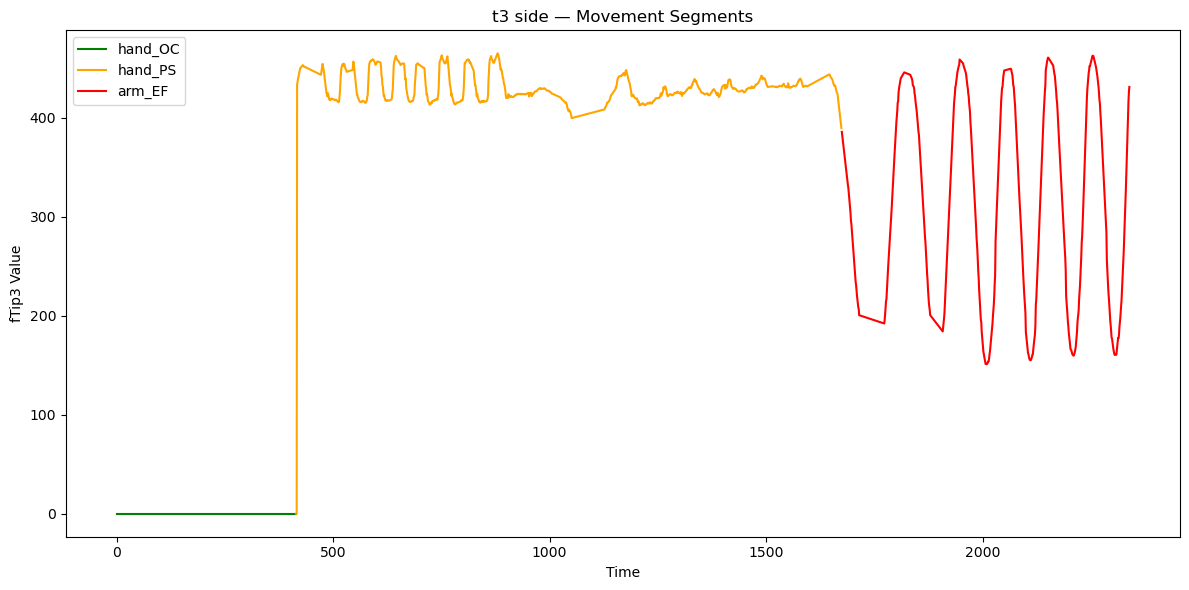

In [389]:
import matplotlib.pyplot as plt

# Example colors for the movements
movement_colors = {
    'hand_OC': 'green',
    'hand_PS': 'orange',
    'arm_EF': 'red'
}

for idx, row in df_movements.iterrows():
    dataset = row['dataset']
    view = row['view']

    # Build dataframe key like before (e.g., 'b1f' for b1 front)
    df_key = dataset + ('f' if view == 'front' else 's')

    if df_key not in dataframes:
        print(f"Skipping {df_key} — data not found.")
        continue

    df = dataframes[df_key]
    
    # Extract x and t data
    x = df[top_feature_pc1].to_numpy()
    t = np.arange(len(x))

    # Get segment indices
    armEF_start, armEF_end = row['arm_EF']
    handOC_start, handOC_end = row['hand_OC']
    handPS_start, handPS_end = row['hand_PS']

    plt.figure(figsize=(12, 6))
    
    # Plot hand_OC segment
    plt.plot(t[handOC_start:handOC_end], x[handOC_start:handOC_end],
             color=movement_colors['hand_OC'], label='hand_OC')

    # Plot hand_PS segment
    plt.plot(t[handPS_start:handPS_end], x[handPS_start:handPS_end],
             color=movement_colors['hand_PS'], label='hand_PS')

    # Plot arm_EF segment
    plt.plot(t[armEF_start:armEF_end], x[armEF_start:armEF_end],
             color=movement_colors['arm_EF'], label='arm_EF')

    plt.title(f"{dataset} {view} — Movement Segments")
    plt.xlabel("Time")
    plt.ylabel(f"{top_feature_pc1} Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


## NOT WORKING YET!!!!!

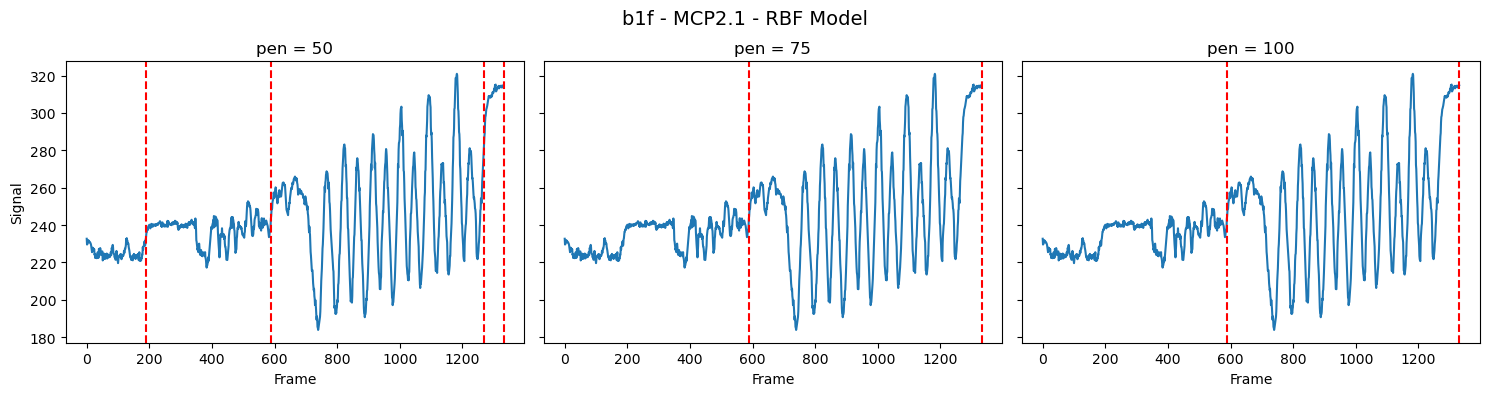

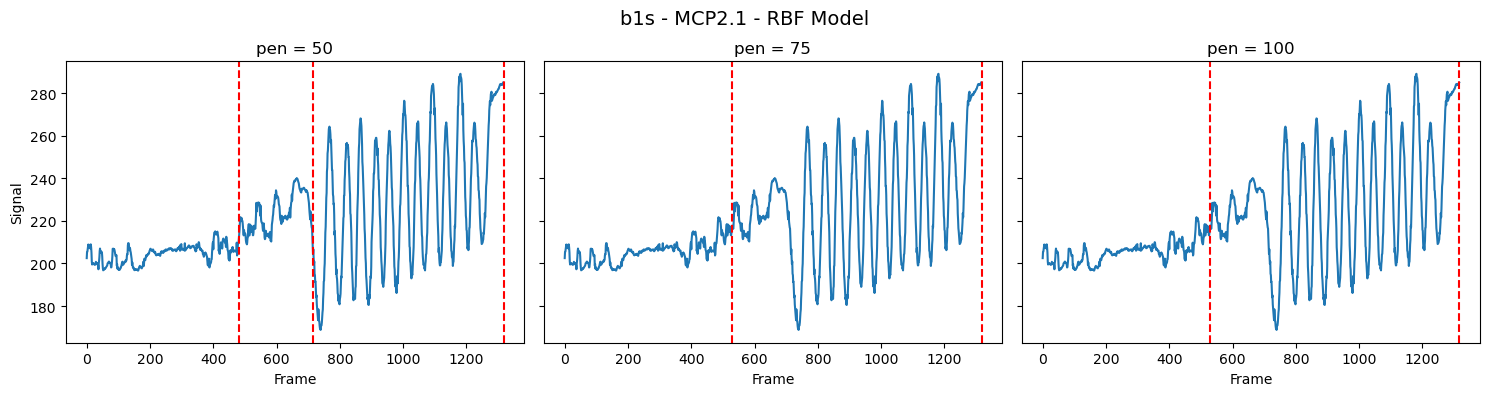

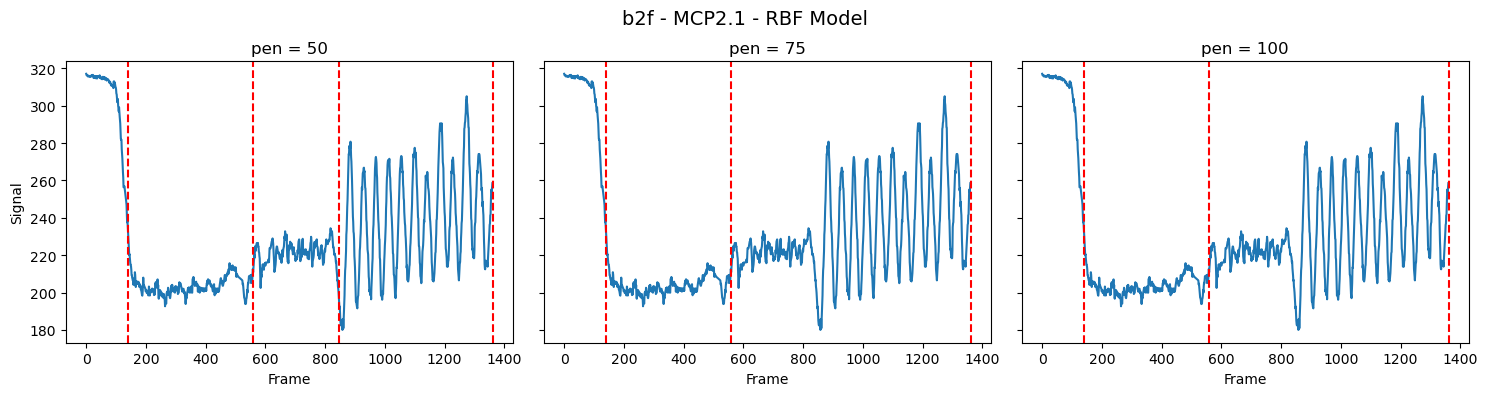

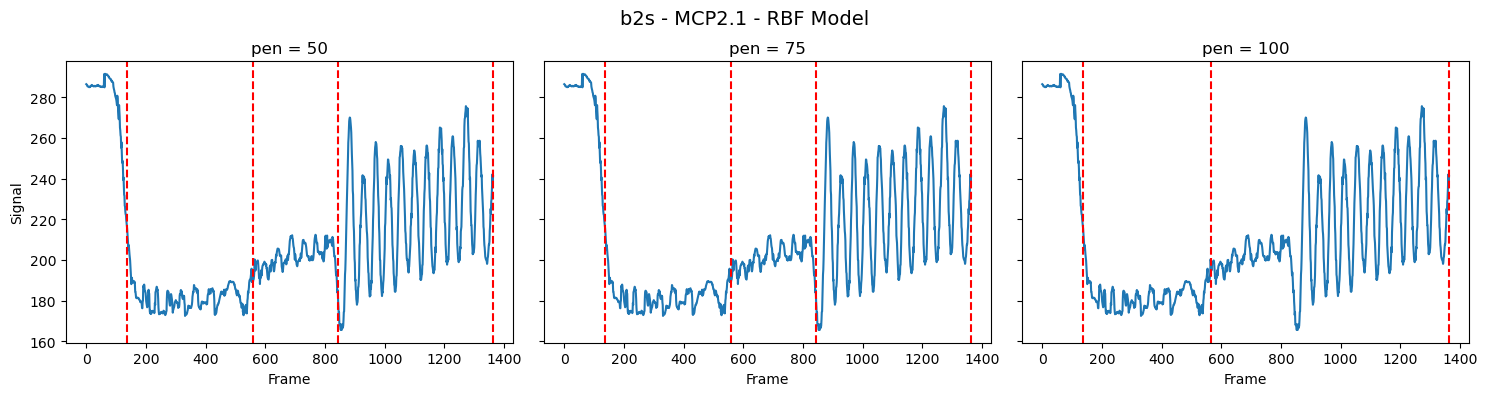

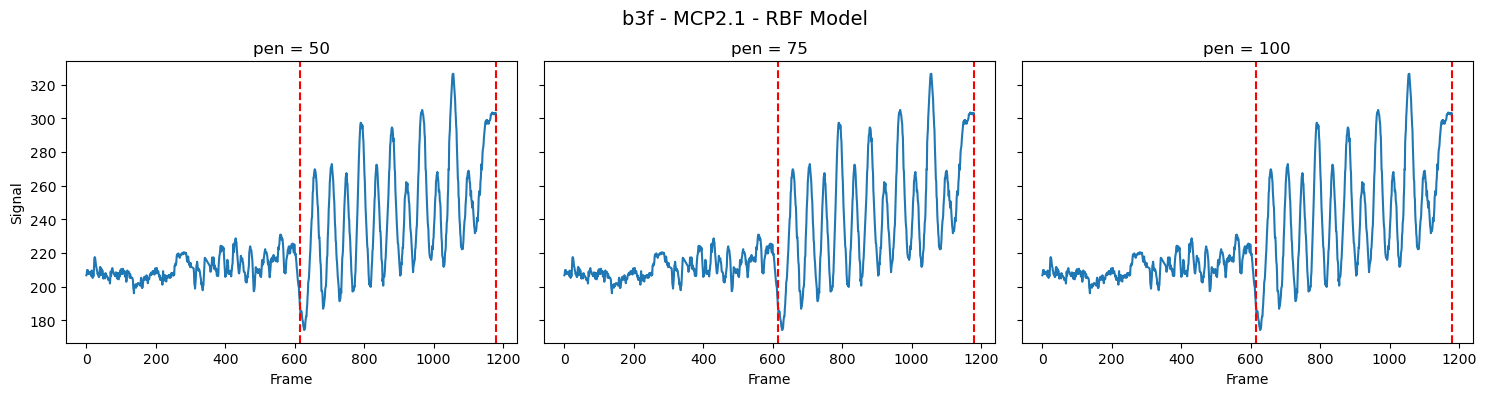

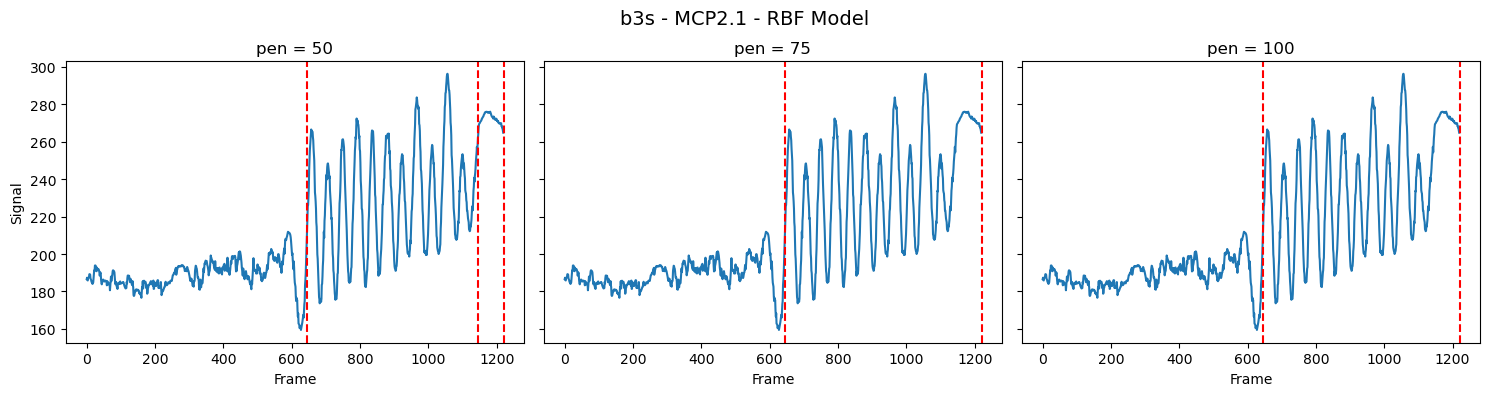

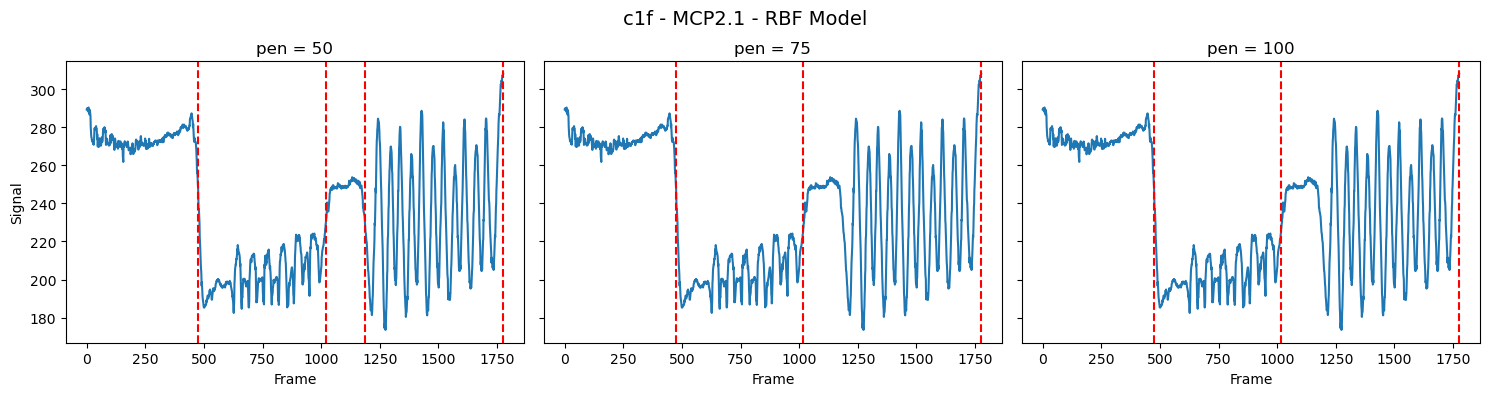

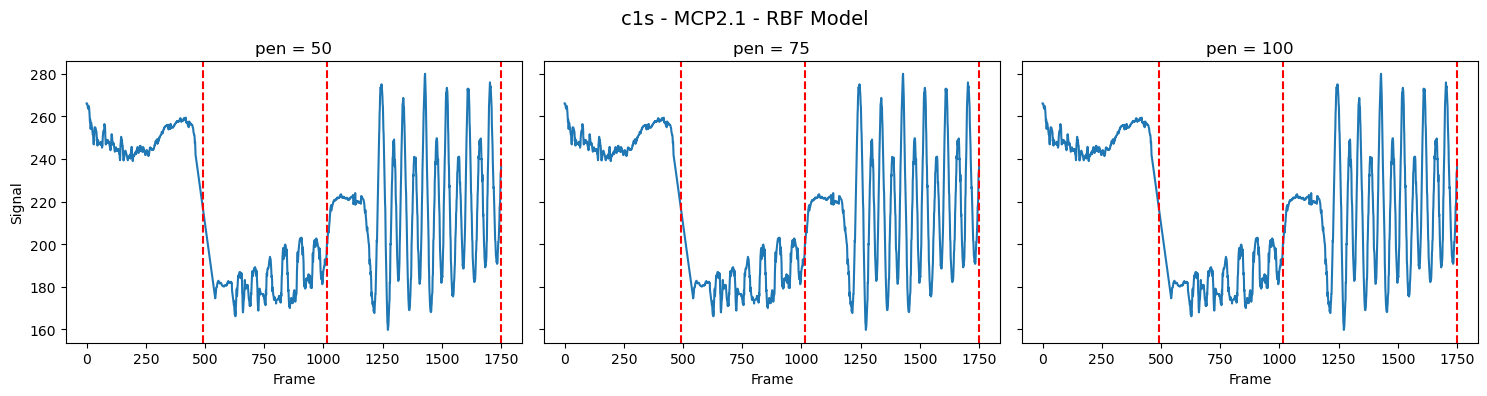

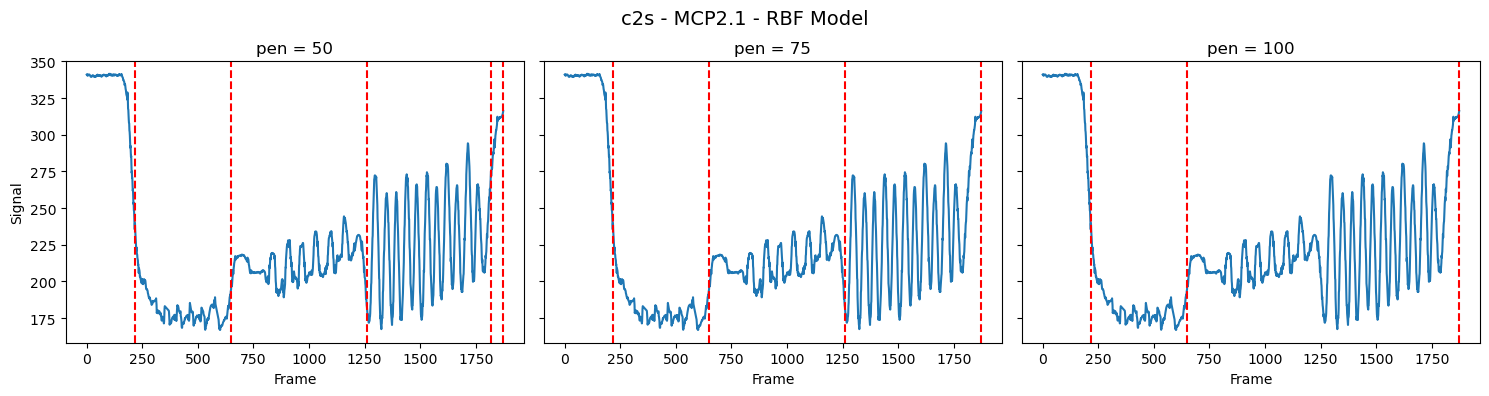

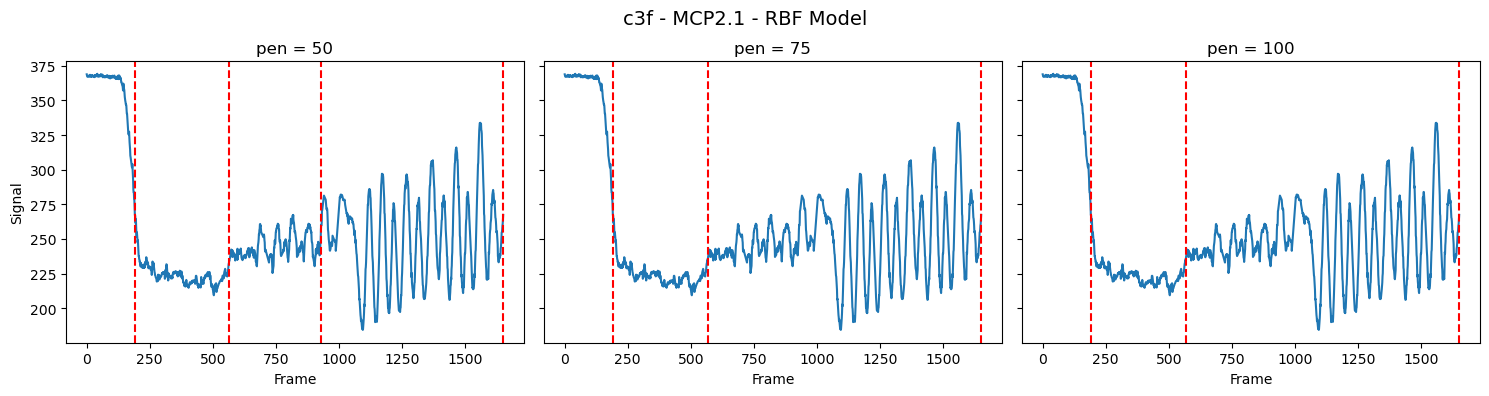

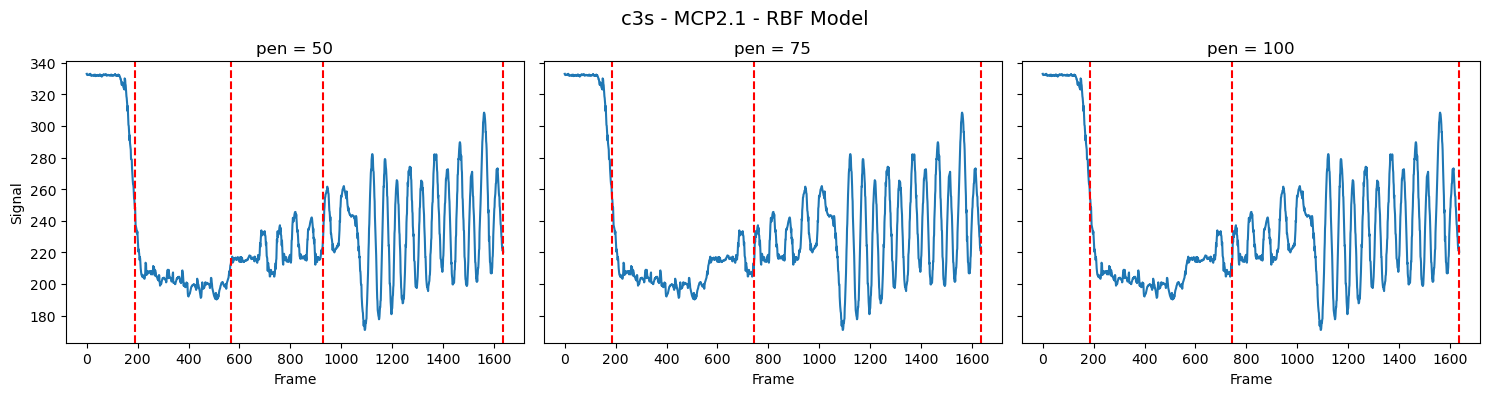

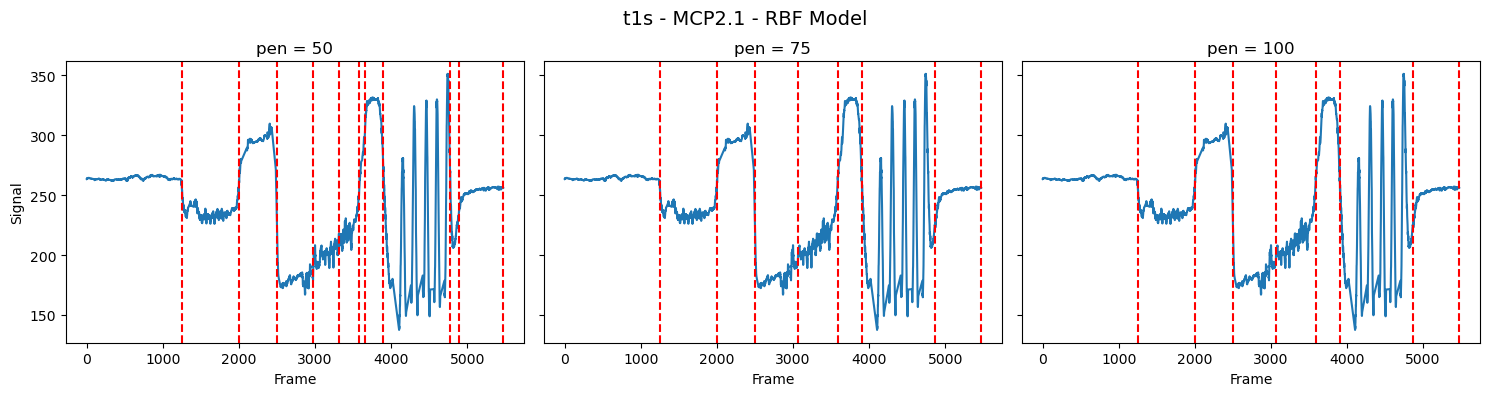

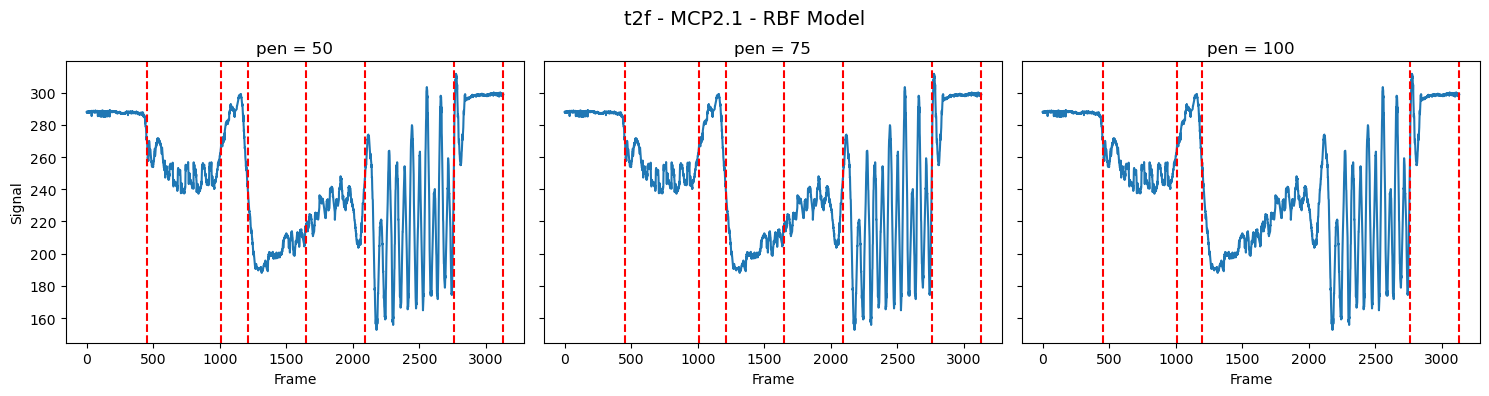

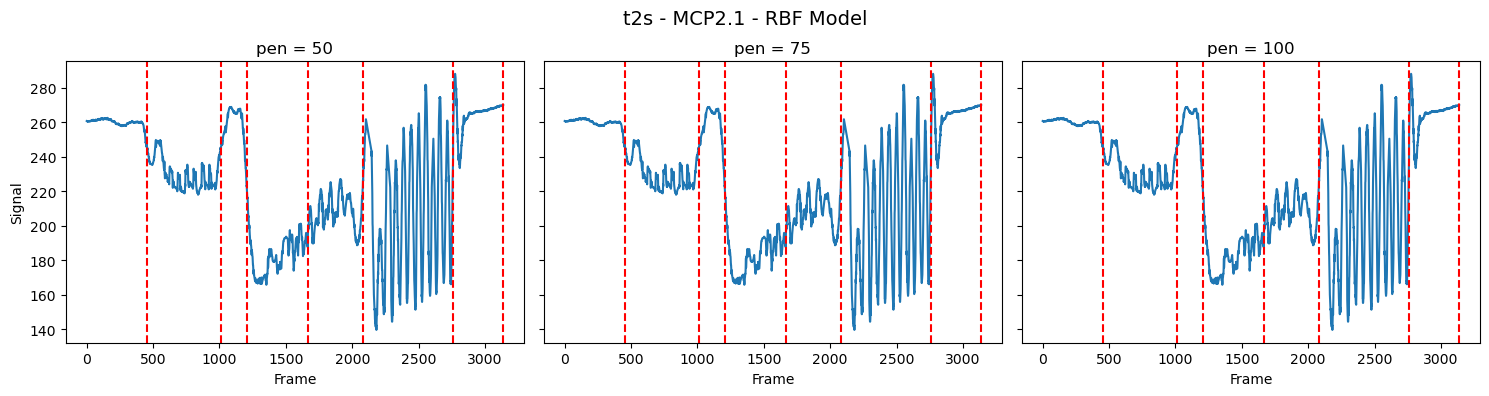

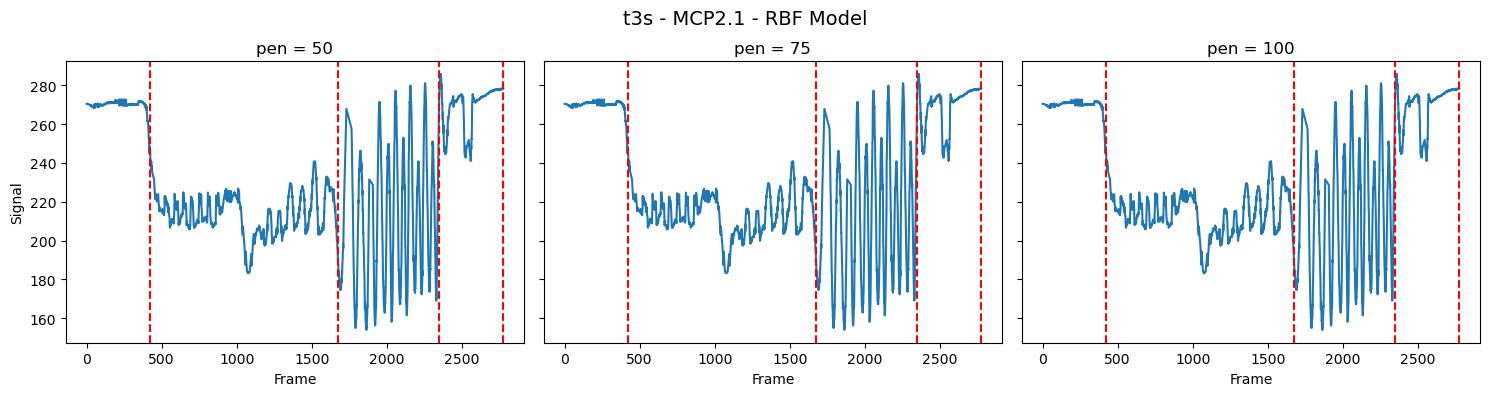

In [241]:
import matplotlib.pyplot as plt
import ruptures as rpt
import pandas as pd
import numpy as np

# Initialize an empty dictionary to hold results by base label
results_dict = {}

# Loop through each dataset
for df_name, data in dataframes.items():
    base_label = df_name[:-1]  # e.g., 'b1' from 'b1f'
    view = 'front' if df_name.endswith('f') else 'side'

    points = data['MCP2.1']
    points_np = points.to_numpy()

    penalties = [50, 75, 100]
    fig, axes = plt.subplots(1, len(penalties), figsize=(15, 4), sharey=True)
    fig.suptitle(f"{df_name} - MCP2.1 - RBF Model", fontsize=14)

    final_cps = None

    for i, pen in enumerate(penalties):
        algo = rpt.Pelt(model='rbf').fit(points_np)
        cps = algo.predict(pen=pen)
        final_cps = cps

        # Plot manually
        ax = axes[i]
        ax.plot(points_np, label="MCP2.1")
        for cp in cps:
            ax.axvline(cp, color='red', linestyle='--')
        ax.set_title(f"pen = {pen}")
        ax.set_xlabel("Frame")
        if i == 0:
            ax.set_ylabel("Signal")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    # Save last cps (pen=100) to results
    if base_label not in results_dict:
        results_dict[base_label] = {'front': None, 'side': None}
    results_dict[base_label][view] = final_cps

# Convert dictionary to DataFrame
df_indices = pd.DataFrame.from_dict(results_dict, orient='index').reset_index()
df_indices.rename(columns={'index': 'dataset'}, inplace=True)


<Figure size 1000x300 with 0 Axes>

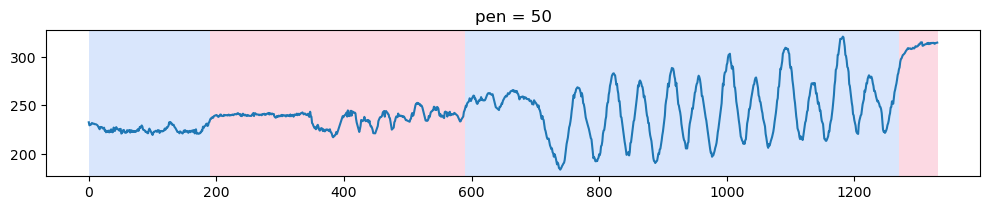

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

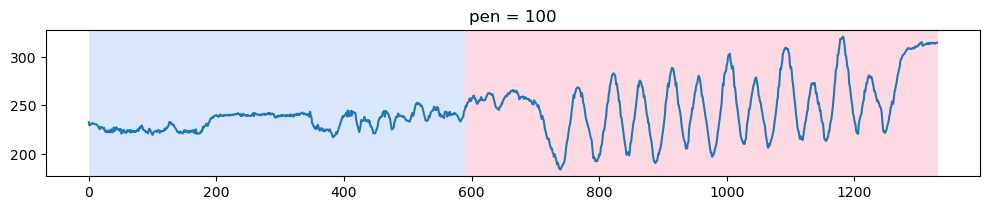

<Figure size 1000x300 with 0 Axes>

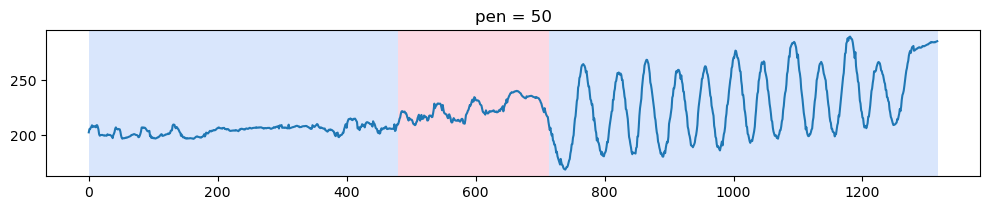

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

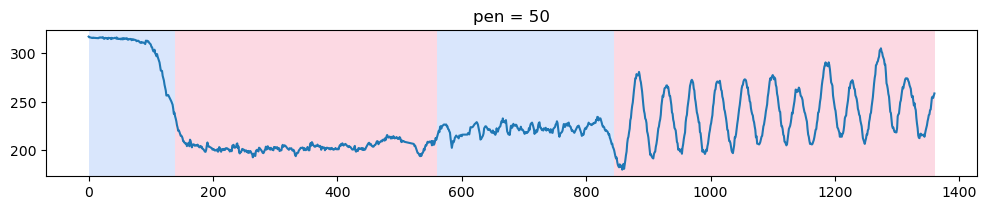

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

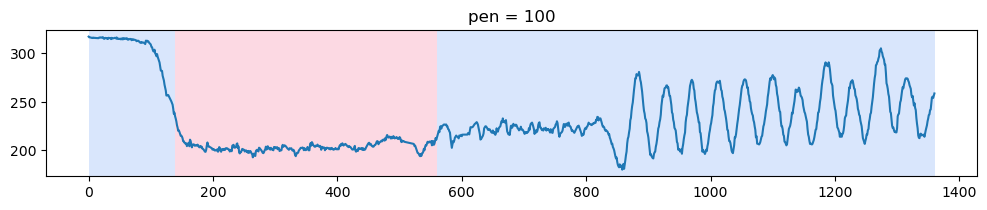

<Figure size 1000x300 with 0 Axes>

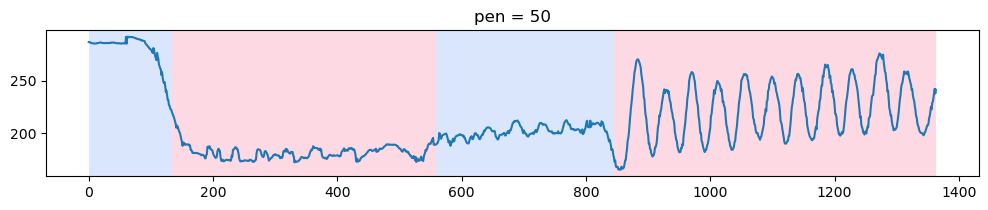

<Figure size 1000x300 with 0 Axes>

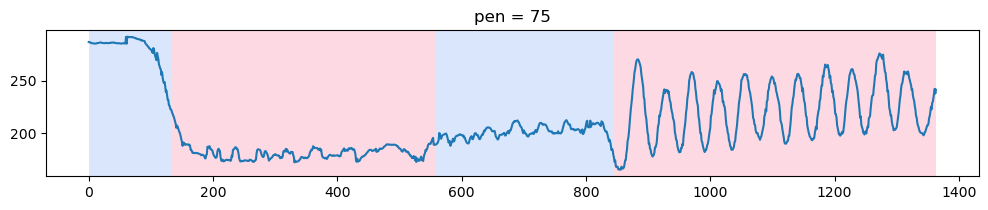

<Figure size 1000x300 with 0 Axes>

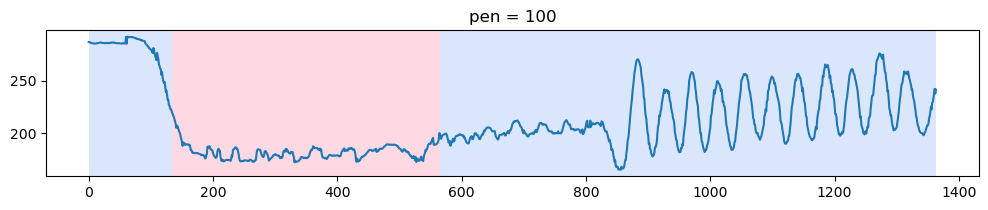

<Figure size 1000x300 with 0 Axes>

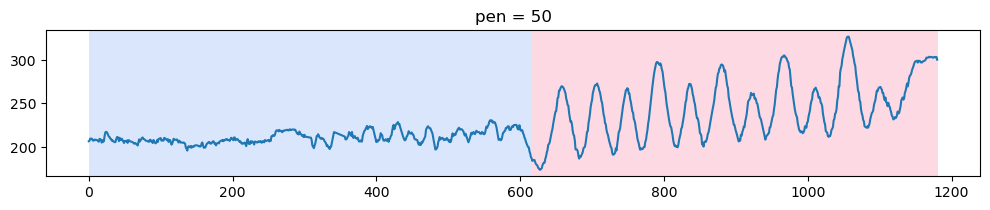

<Figure size 1000x300 with 0 Axes>

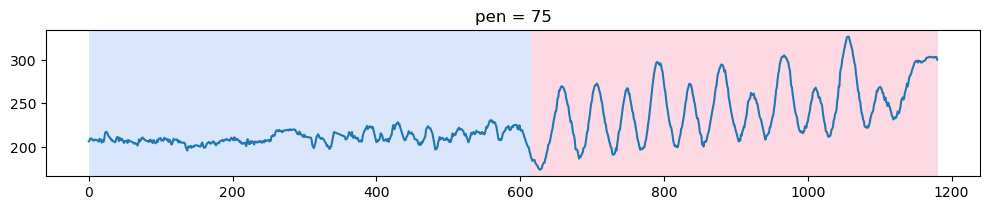

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

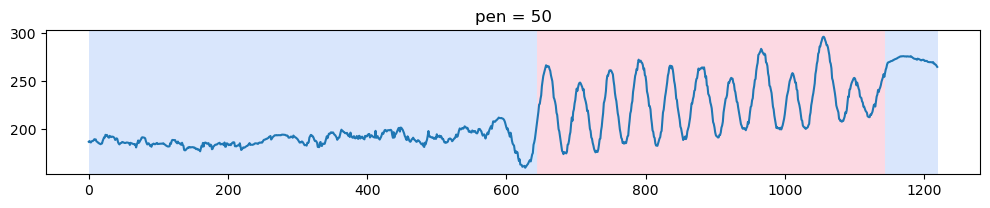

<Figure size 1000x300 with 0 Axes>

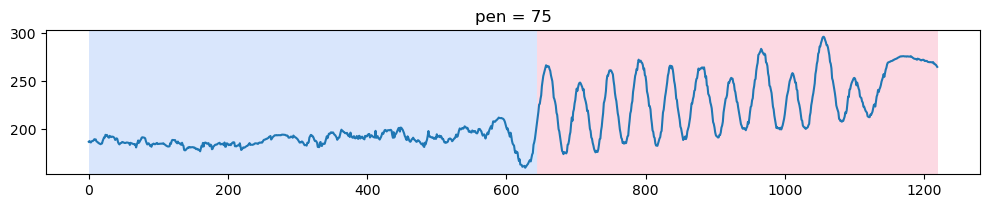

<Figure size 1000x300 with 0 Axes>

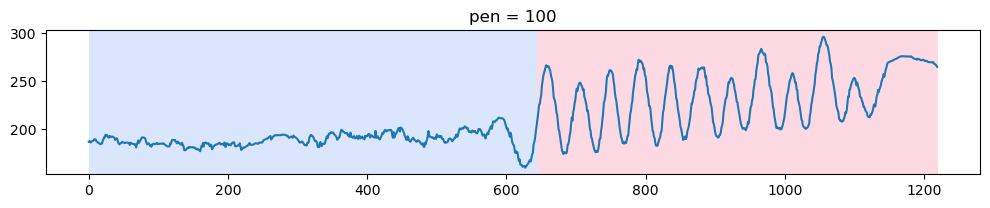

<Figure size 1000x300 with 0 Axes>

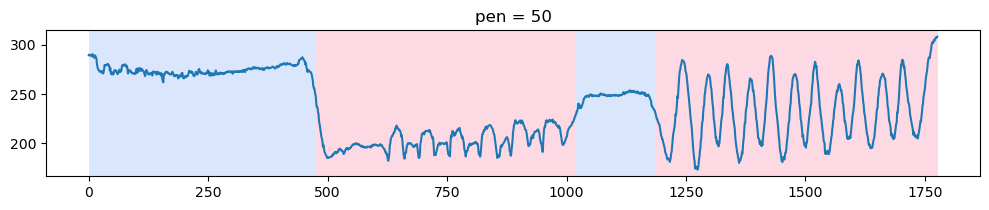

<Figure size 1000x300 with 0 Axes>

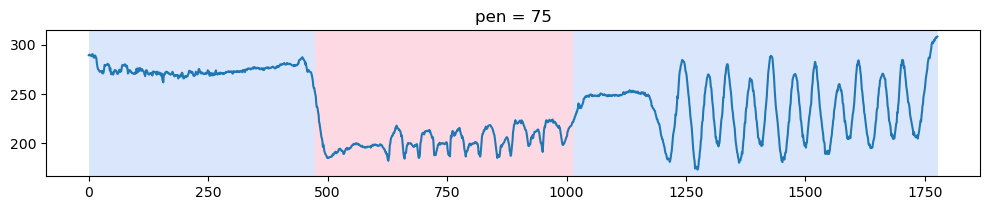

<Figure size 1000x300 with 0 Axes>

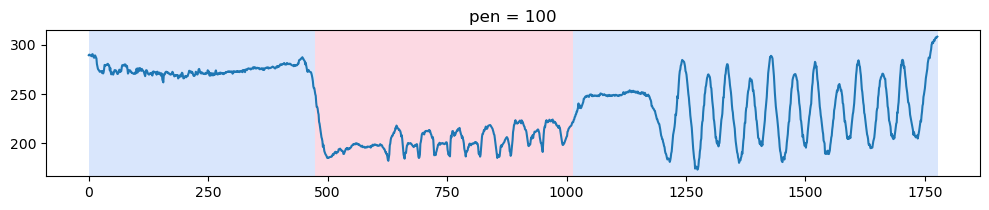

<Figure size 1000x300 with 0 Axes>

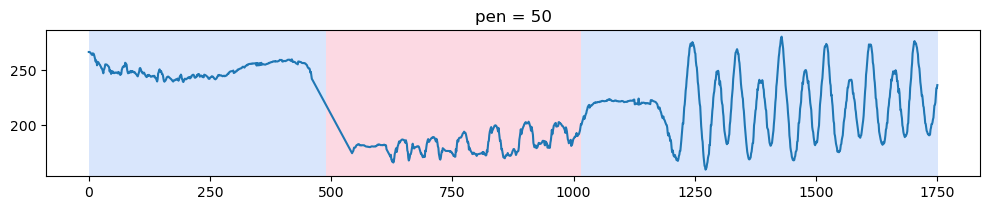

KeyboardInterrupt: 

In [239]:
# Initialize an empty dictionary to hold results by base label
results_dict = {}

for df_name, data in dataframes.items():
    # Extract base label (e.g. 'b1' from 'b1f' or 'b1s')
    base_label = df_name[:-1]  # remove last character
    view = 'front' if df_name.endswith('f') else 'side'

    points = data['MCP2.1']
    points_np = points.to_numpy()

    for pen in [50, 75, 100]:
        algo = rpt.Pelt(model='rbf').fit(points_np)
        cps = algo.predict(pen=pen)

        plt.figure(figsize=(10, 3))
        rpt.display(points_np, cps)
        plt.title(f'pen = {pen}')
        plt.show()


    # Initialize dict entry if not exists
    if base_label not in results_dict:
        results_dict[base_label] = {'front': None, 'side': None}

    # Save change points in proper column
    results_dict[base_label][view] = cps

# Convert dictionary to DataFrame
df_indices = pd.DataFrame.from_dict(results_dict, orient='index').reset_index()
df_indices.rename(columns={'index': 'dataset'}, inplace=True)


In [228]:
df_indices['front_length'] = df_indices['front'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [229]:
df_indices

dataset                           front  \
0      b1  [1730, 2510, 3215, 4015, 4258]   
1      b2   [365, 1340, 2160, 2960, 3271]   
2      b3   [345, 1270, 2050, 2845, 3053]   
3      c1   [340, 2690, 3425, 4420, 4936]   
4      c2         [535, 1325, 2195, 3219]   
5      c3         [580, 1385, 2265, 3268]   
6      t1                      [195, 622]   
7      t2                           [522]   
8      t3               [305, 2145, 3531]   

                                        side  front_length  
0                   [2010, 2830, 3535, 4556]             5  
1                          [400, 2355, 3223]             5  
2                          [350, 1970, 2947]             5  
3              [420, 1295, 1985, 2720, 3013]             5  
4              [530, 1390, 2335, 3105, 3368]             4  
5                                      [619]             4  
6                                      [498]             2  
7  [275, 1160, 1305, 2180, 2400, 3110, 3575]             1  
8                                       None             3

In [230]:
success_list = []

for _, row in df_indices.iterrows():
    # Check if number of change points in 'front' view is 4 or 5
    num_cp = len(row['front']) if isinstance(row['front'], list) else 0

    if num_cp in [1, 2, 3, 4, 5, 6, 7]:
        success_list.append(f"{row['dataset']}f")
    else:
        success_list.append(f"{row['dataset']}s")

print(success_list)


['b1f', 'b2f', 'b3f', 'c1f', 'c2f', 'c3f', 't1f', 't2f', 't3f']


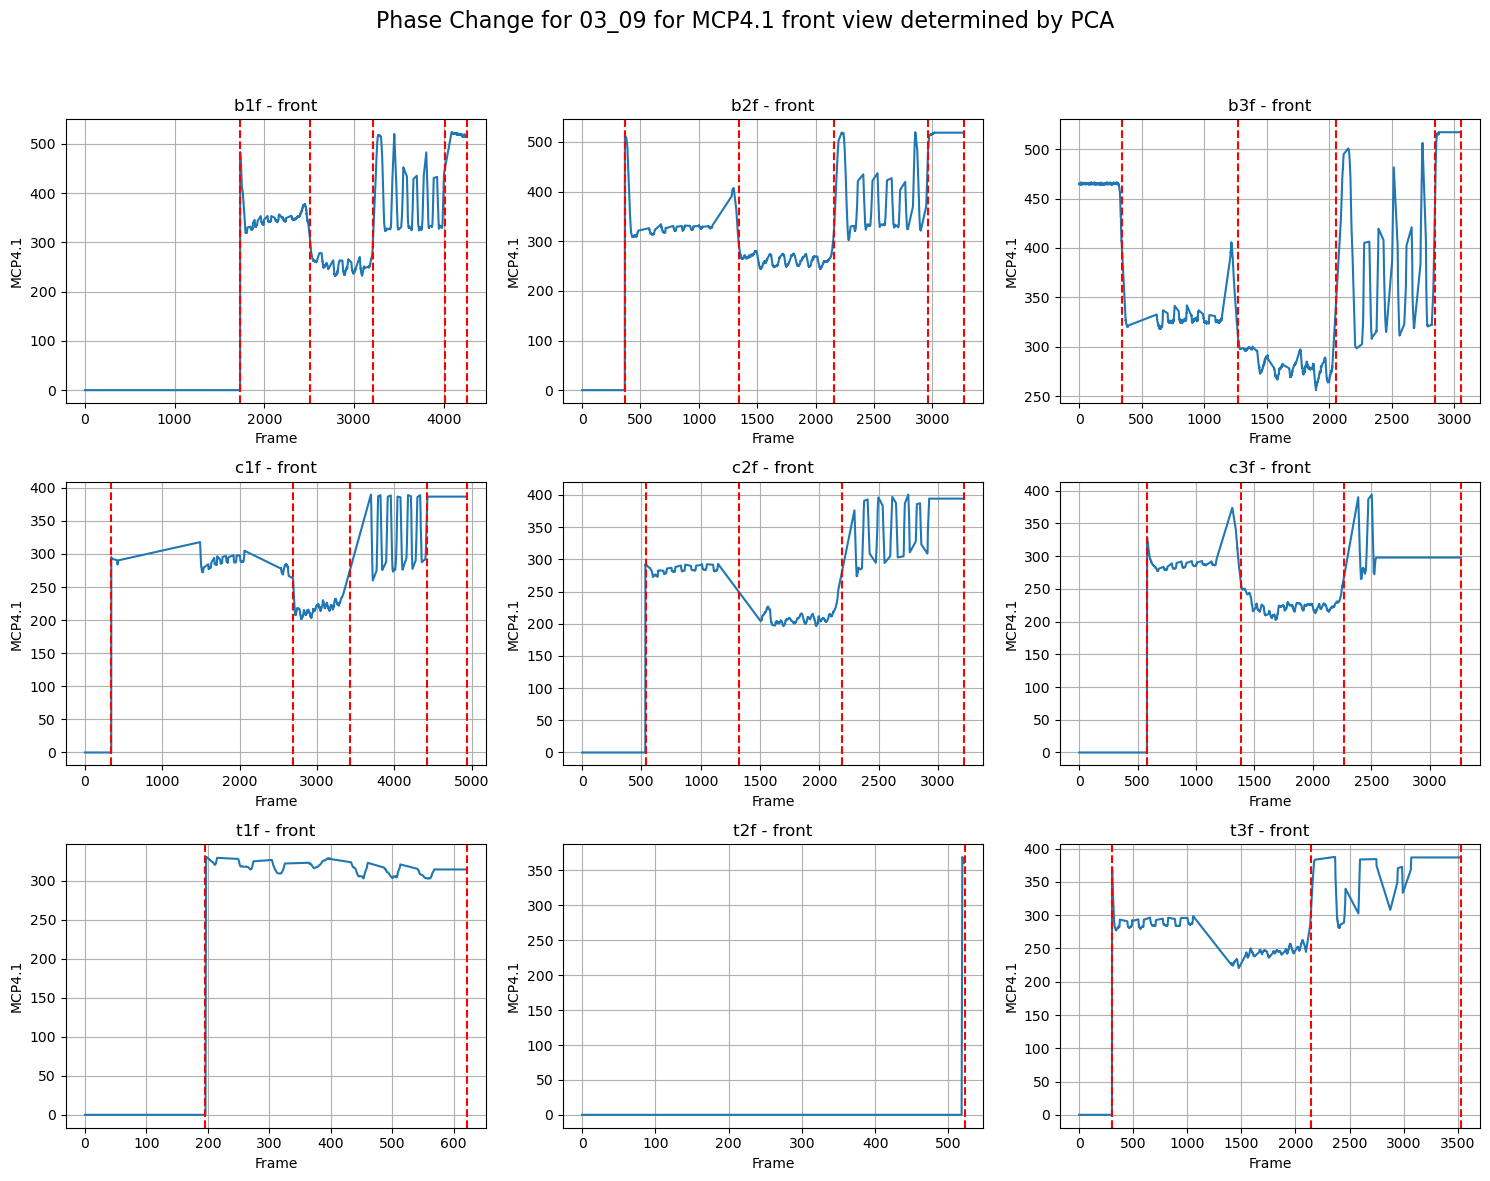

In [231]:
# Define number of plots per row
plots_per_row = 3
num_plots = len(success_list)
num_rows = int(np.ceil(num_plots / plots_per_row))

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 4 * num_rows))
axes = axes.flatten()  # Make it 1D so it's easier to index

for i, name in enumerate(success_list):
    base_name = name[:-1]
    view = 'front' if name.endswith('f') else 'side'

    # Get signal
    df = dataframes[name]
    signal = df['MCP4.1'].to_numpy()
    time = np.arange(len(signal))

    # Get change points
    row = df_indices[df_indices['dataset'] == base_name]
    change_points = row.iloc[0][view] if not row.empty else []

    # Plot in subplot
    ax = axes[i]
    ax.plot(time, signal, label='MCP4.1')
    for cp in change_points:
        ax.axvline(cp, color='red', linestyle='--')

    ax.set_title(f"{name} - {view}")
    ax.set_xlabel("Frame")
    ax.set_ylabel("MCP4.1")
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add overall title here
fig.suptitle("Phase Change for 03_09 for MCP4.1 front view determined by PCA", fontsize=16)

# Adjust layout to make room for suptitle
fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [139]:
# Create empty DataFrame to hold results
columns = ['dataset', 'movement', 'data', 'time', 'indices']
df_movements = pd.DataFrame(columns=columns)

for name in success_list:
    base_name = name[:-1]               # 'b1' from 'b1f'
    view = 'front' if name.endswith('f') else 'side'
    
    # 1. Get signal and time
    df = dataframes[name]
    x = df['MCP1.1'].to_numpy()
    t = df.index.to_numpy() if 'time' not in df else df['time'].to_numpy()

    # 2. Get change points
    row = df_indices[df_indices['dataset'] == base_name]
    if row.empty:
        continue  # skip if no match

    change_points = row.iloc[0][view]
    if len(change_points) < 3:
        continue  # not enough points to split into 3 parts

    # 3. Define movement segments
    segment_info = {
        'hand_OC': (change_points[0], change_points[1]),
        'hand_PS': (change_points[1], change_points[2]),
        'arm_EF': (change_points[2], len(x))  # to end
    }

    for movement, (start, end) in segment_info.items():
        if end - start < 400:
            continue  # skip short segments

        segment_data = x[start:end]
        segment_time = t[start:end]

        df_movements = pd.concat([
            df_movements,
            pd.DataFrame([{
                'dataset': base_name,
                'movement': movement,
                'data': segment_data,
                'time': segment_time,
                'indices': (start, end)
            }])
        ], ignore_index=True)

# preview result
df_movements.head()
df_movements.tail()


dataset movement                                               data  \
16      c3  hand_PS  [309.50228428571427, 308.48220842105263, 307.4...   
17      c3   arm_EF  [336.15594, 341.42813, 343.06091, 345.35739, 3...   
18      t3  hand_OC  [398.48032, 393.82822, 391.99323, 391.08386, 3...   
19      t3  hand_PS  [278.54636, 275.8075, 273.53549, 270.30017, 26...   
20      t3   arm_EF  [301.40118, 305.00659, 308.67151, 311.48022, 3...   

                                                 time       indices  
16  [1416, 1417, 1418, 1419, 1420, 1421, 1422, 142...  (1415, 2325)  
17  [2326, 2327, 2328, 2329, 2330, 2331, 2332, 233...  (2325, 3368)  
18  [296, 297, 298, 299, 300, 301, 302, 303, 304, ...   (295, 1320)  
19  [1321, 1322, 1323, 1324, 1325, 1326, 1327, 132...  (1320, 2140)  
20  [2141, 2142, 2143, 2144, 2145, 2146, 2147, 214...  (2140, 3531)

In [161]:
# Apply and create new columns
df_movements[['peaks', 'troughs', 'euclidean_dis']] = df_movements.apply(compute_peaks_troughs, axis=1)
df_movements

Error processing row 13: 'NoneType' object is not subscriptable
Error processing row 14: 'NoneType' object is not subscriptable


dataset movement                                               data  \
0       b1  hand_OC  [0.0, 448.0502, 445.30121, 443.25018, 442.3430...   
1       b1  hand_PS  [317.83844, 312.74094, 311.93942, 311.05396, 3...   
2       b1   arm_EF  [343.40897, 345.45416, 349.21518, 351.87399, 3...   
3       b2  hand_OC  [439.14294, 439.14536, 432.31442, 423.14078, 4...   
4       b2  hand_PS  [311.82791, 312.01193, 310.13269, 306.78973, 3...   
5       b2   arm_EF  [335.06079, 339.45883, 342.71967, 346.3273, 34...   
6       b3  hand_OC  [452.02008, 448.15372, 445.60977, 438.82437, 4...   
7       b3  hand_PS  [325.61445755458516, 325.1283611790393, 324.64...   
8       b3   arm_EF  [350.39087590909094, 353.8283927272727, 357.26...   
9       c1  hand_OC  [0.0, 0.0, 442.80359, 441.81766, 440.32602, 43...   
10      c1  hand_PS  [298.9317, 297.18646, 296.37354, 295.71088, 29...   
11      c1   arm_EF  [330.20517, 332.38062, 337.83807, 337.98004, 3...   
12      c2  hand_OC  [349.91284, 349.6095, 348.84729, 347.63525, 34...   
13      c2  hand_PS  [262.88562, 261.86145, 260.20886, 259.50739, 2...   
14      c2   arm_EF  [291.27039, 293.63306, 296.07333, 297.79172, 3...   
15      c3  hand_OC  [419.08252, 416.78674, 411.8371, 409.60016, 40...   
16      c3  hand_PS  [309.50228428571427, 308.48220842105263, 307.4...   
17      c3   arm_EF  [336.15594, 341.42813, 343.06091, 345.35739, 3...   
18      t3  hand_OC  [398.48032, 393.82822, 391.99323, 391.08386, 3...   
19      t3  hand_PS  [278.54636, 275.8075, 273.53549, 270.30017, 26...   
20      t3   arm_EF  [301.40118, 305.00659, 308.67151, 311.48022, 3...   

                                                 time       indices  \
0   [1746, 1747, 1748, 1749, 1750, 1751, 1752, 175...  (1745, 2515)   
1   [2516, 2517, 2518, 2519, 2520, 2521, 2522, 252...  (2515, 3215)   
2   [3216, 3217, 3218, 3219, 3220, 3221, 3222, 322...  (3215, 4258)   
3   [401, 402, 403, 404, 405, 406, 407, 408, 409, ...   (400, 1345)   
4   [1346, 1347, 1348, 1349, 1350, 1351, 1352, 135...  (1345, 2155)   
5   [2156, 2157, 2158, 2159, 2160, 2161, 2162, 216...  (2155, 3271)   
6   [336, 337, 338, 339, 340, 341, 342, 343, 344, ...   (335, 1330)   
7   [1331, 1332, 1333, 1334, 1335, 1336, 1337, 133...  (1330, 2070)   
8   [2071, 2072, 2073, 2074, 2075, 2076, 2077, 207...  (2070, 3053)   
9   [431, 432, 433, 434, 435, 436, 437, 438, 439, ...   (430, 1300)   
10  [1301, 1302, 1303, 1304, 1305, 1306, 1307, 130...  (1300, 1980)   
11  [1981, 1982, 1983, 1984, 1985, 1986, 1987, 198...  (1980, 3013)   
12  [496, 497, 498, 499, 500, 501, 502, 503, 504, ...   (495, 1375)   
13  [1376, 1377, 1378, 1379, 1380, 1381, 1382, 138...  (1375, 2170)   
14  [2171, 2172, 2173, 2174, 2175, 2176, 2177, 217...  (2170, 3219)   
15  [571, 572, 573, 574, 575, 576, 577, 578, 579, ...   (570, 1415)   
16  [1416, 1417, 1418, 1419, 1420, 1421, 1422, 142...  (1415, 2325)   
17  [2326, 2327, 2328, 2329, 2330, 2331, 2332, 233...  (2325, 3368)   
18  [296, 297, 298, 299, 300, 301, 302, 303, 304, ...   (295, 1320)   
19  [1321, 1322, 1323, 1324, 1325, 1326, 1327, 132...  (1320, 2140)   
20  [2141, 2142, 2143, 2144, 2145, 2146, 2147, 214...  (2140, 3531)   

                                                peaks  \
0          [1973, 2085, 2142, 2195, 2281, 2370, 2469]   
1                [2639, 2769, 2869, 2966, 3063, 3154]   
2                [3303, 3441, 3565, 3679, 3791, 3904]   
3          [512, 666, 765, 835, 894, 982, 1057, 1293]   
4                [1453, 1622, 1726, 1813, 1916, 2011]   
5          [2247, 2384, 2506, 2629, 2742, 2853, 2915]   
6    [433, 540, 687, 772, 880, 965, 1045, 1177, 1291]   
7          [1485, 1543, 1657, 1765, 1870, 1961, 2040]   
8   [2164, 2297, 2356, 2411, 2472, 2524, 2577, 263...   
9         [669, 730, 801, 890, 985, 1076, 1173, 1261]   
10                                 [1572, 1712, 1848]   
11  [2182, 2238, 2504, 2600, 2690, 2743, 2818, 288...   
12        [673, 738, 805, 891, 983, 1085, 1160, 1283]   
13           

## Viewing peaks and troughs

KeyError: 'peaks'

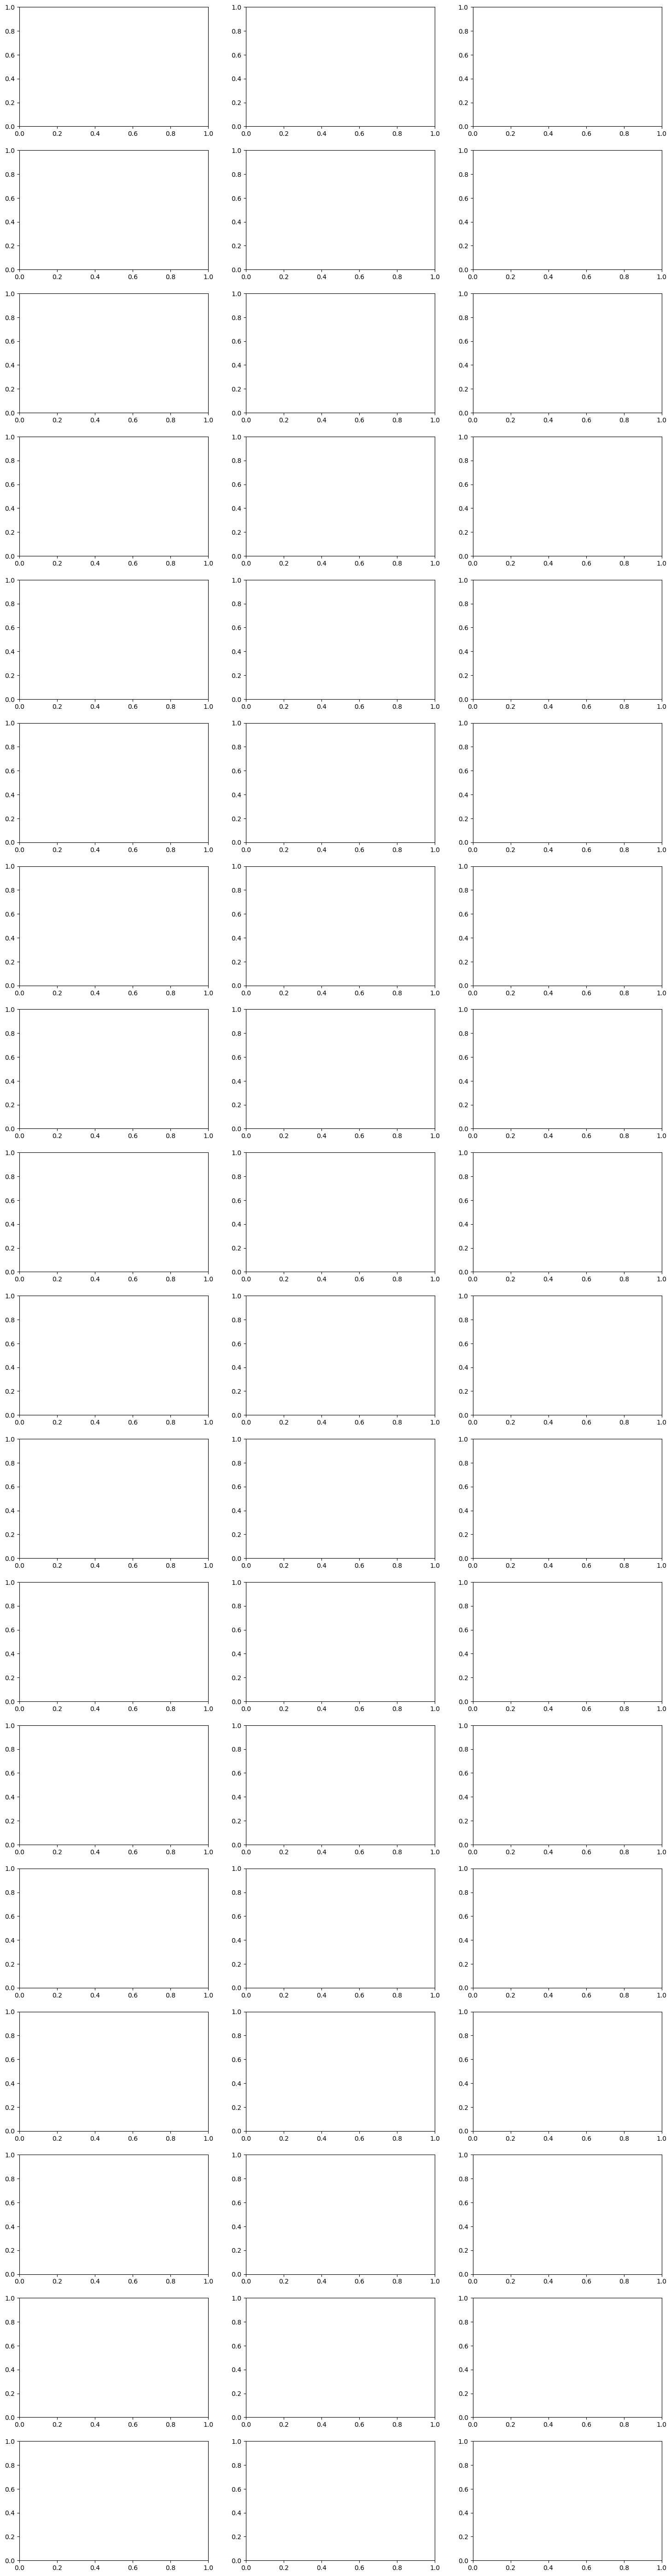

In [375]:
# Filter rows where 'peaks' is not None
# valid_rows = df_movements[df_movements['peaks'].notna()].reset_index()

num_plots = len(df_movements)
cols = 3
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()


for i, (idx, row) in enumerate(df_movements.iterrows()):
    ax = axes[i]

    if row['peaks'] is None:
        fig.delaxes(ax)
        continue


    if row['movement'] == 'hand_OC':
        data = row['euclidean_dis']
    else:
        data = row['data']
    
    # Plot time vs data
    ax.plot(row['time'], data, label='Signal', color='black')

    # Plot peaks (if any)
    if isinstance(row['peaks'], (np.ndarray, list)):
        ax.plot(row['peaks'], np.interp(row['peaks'], row['time'], data), 'ro', label='Peaks')

    # Plot troughs (if any)
    if isinstance(row['troughs'], (np.ndarray, list)):
        ax.plot(row['troughs'], np.interp(row['troughs'], row['time'], data), 'bo', label='Troughs')

    # Add titles and labels
    ax.set_title(f"{row['dataset']} - {row['movement']}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
